# Prediction_of_H1N1_vaccination
Your task is to predict whether people got H1N1 vaccines using information they shared about their backgrounds, opinions, and health behaviors.



## Data Understanding

### Import Libraries and Data

In [1499]:
import pandas as pd
import numpy as np
import scipy
import itertools
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier
import optuna
from tensorflow.keras.losses import BinaryCrossentropy
from IPython.display import clear_output
import category_encoders
try:
    from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer
except:
    !pip install autoimpute
    from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer

from lightgbm import plot_importance
from sklearn.metrics import confusion_matrix, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler
clear_output();
%matplotlib inline


In [1500]:
train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
submission = pd.read_csv('../Prediction_of_H1N1_vaccination/data/submission.csv')

In [1501]:
train.shape, target.shape, test.shape, submission.shape

((42154, 38), (42154, 2), (28104, 38), (28104, 2))

In [1502]:
df=pd.concat([train,target],axis=1)
df.shape

(42154, 40)

#### Random seed

In [1503]:
random_seed=42
np.random.seed(random_seed)

### Data Describe and EDA

#### Pandas Profiling

In [1504]:
#ProfileReport(df, title="Pandas Profiling Report", explorative=True)

#### Univariate analysis

Including Data re-expression, type casting, Outliers

In [1505]:
def EDA_plot1(df,column):  
    df[column].value_counts(sort=False)[::-1].plot(kind='bar',title=column+'counts')
    pd.crosstab(df[column],df['vacc_h1n1_f'],normalize='columns').plot(kind='bar',title=column + ' distribution by target')

In [1506]:
type_feature={}

##### (target) vacc_h1n1_f

- Description : Whether respondent received H1N1 flu vaccine.

<AxesSubplot:title={'center':'vacc_h1n1_f'}>

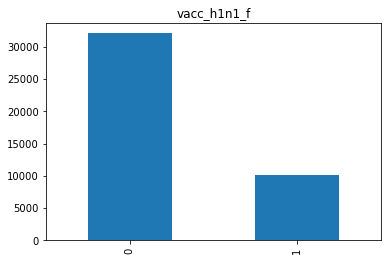

In [1507]:
df['vacc_h1n1_f'].value_counts().plot(kind='bar',title='vacc_h1n1_f')

- Note : Nominal, Imbalanced Data

In [1508]:
type_feature['vacc_h1n1_f'] = 'bool'

##### vacc_seas_f

- Description : Whether respondent received seasonal flu vaccine.

<AxesSubplot:title={'center':'vacc_seas_f'}>

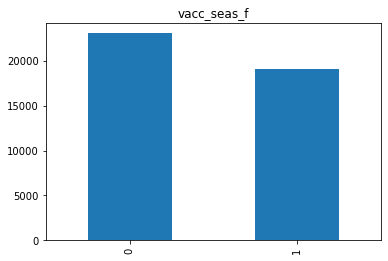

In [1509]:
df['vacc_seas_f'].value_counts().plot(kind='bar',title='vacc_seas_f')

- Note : boolean, Imbalanced Data, dependent variable

In [1510]:
type_feature['vacc_seas_f'] = 'bool'

##### h1n1_concern 

- Description : Level of concern about the H1N1 flu.   
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.   

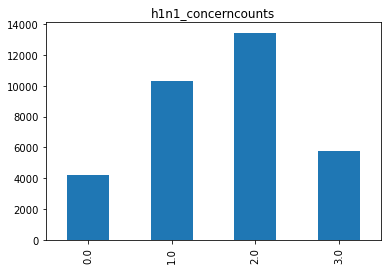

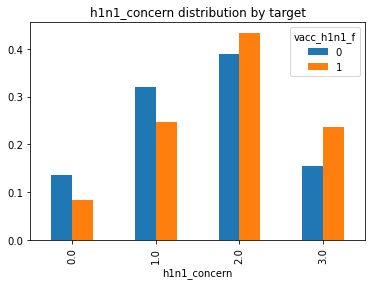

In [1511]:
EDA_plot1(df,'h1n1_concern')

- Note : ordinal type

In [1512]:
type_feature['h1n1_concern'] = 'ordinal'

##### h1n1_knowledge

- Description : Level of knowledge about H1N1 flu.   
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.   

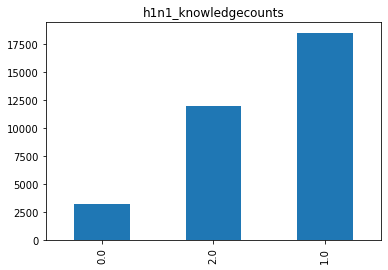

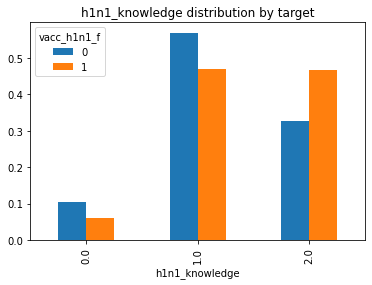

In [1513]:
EDA_plot1(df,'h1n1_knowledge')

- Note : Disordered

In [1514]:
type_feature['h1n1_knowledge'] = 'nominal'

##### behavioral_antiviral_meds

- Description : Has taken antiviral medications.

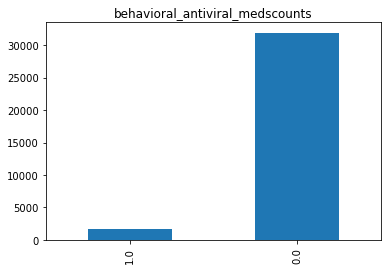

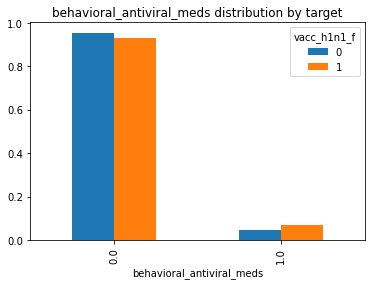

In [1515]:
EDA_plot1(df,'behavioral_antiviral_meds')

- Note : boolean

In [1516]:
type_feature['behavioral_antiviral_meds'] = 'bool'

##### behavioral_avoidance

- Description : Has avoided close contact with others with flu-like symptoms.

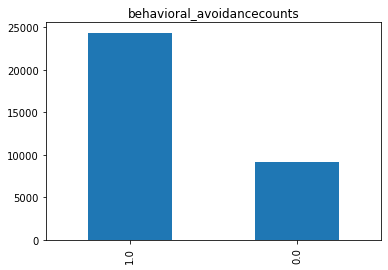

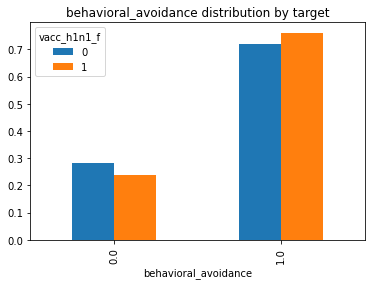

In [1517]:
EDA_plot1(df,'behavioral_avoidance')

- Note : boolean

In [1518]:
type_feature['behavioral_avoidance'] = 'bool'

##### behavioral_face_mask

- Description : Has bought a face mask.

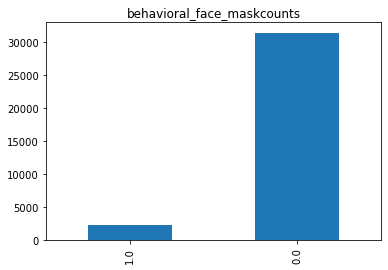

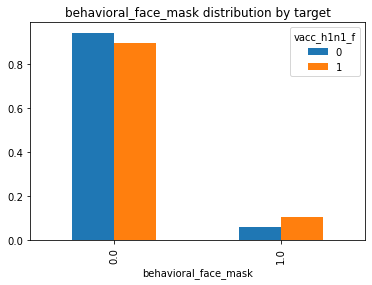

In [1519]:
EDA_plot1(df,'behavioral_face_mask')

- Note : boolean

In [1520]:
type_feature['behavioral_face_mask'] = 'bool'

##### behavioral_wash_hands

- Description : Has frequently washed hands or used hand sanitizer.

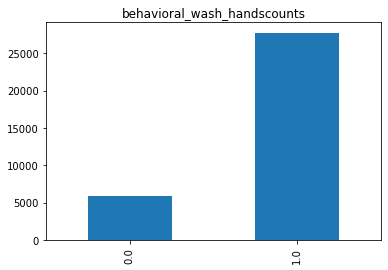

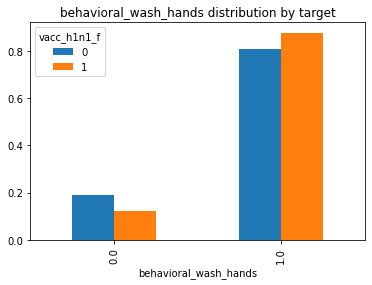

In [1521]:
EDA_plot1(df,'behavioral_wash_hands')

- Note : boolean

In [1522]:
type_feature['behavioral_wash_hands'] = 'bool'

##### behavioral_large_gatherings

- Description : Has reduced time at large gatherings.

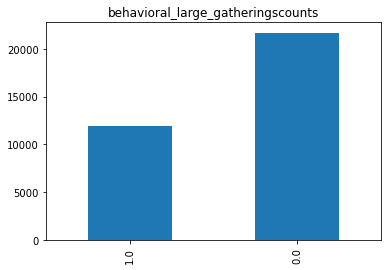

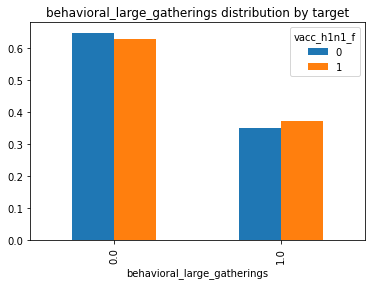

In [1523]:
EDA_plot1(df,'behavioral_large_gatherings')

- Note : boolean

In [1524]:
type_feature['behavioral_large_gatherings'] = 'bool'

##### behavioral_outside_home

- Description : Has reduced contact with people outside of own household.

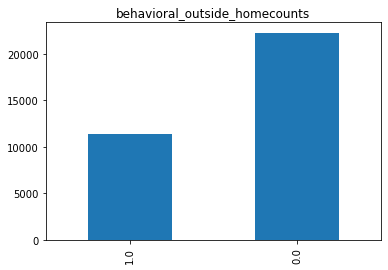

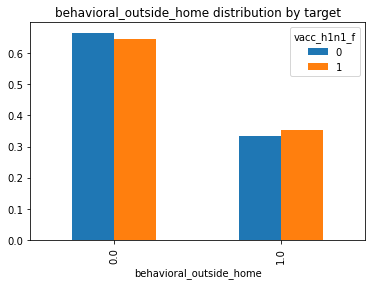

In [1525]:
EDA_plot1(df,'behavioral_outside_home')

- Note : boolean

In [1526]:
type_feature['behavioral_outside_home'] = 'bool'

##### behavioral_touch_face

- Description : Has avoided touching eyes, nose, or mouth.

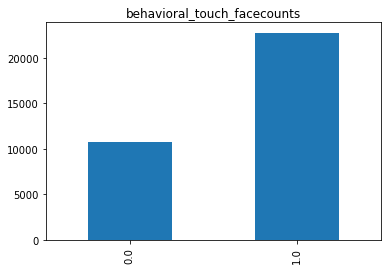

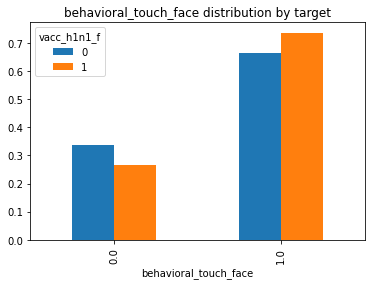

In [1527]:
EDA_plot1(df,'behavioral_touch_face')

- Note : boolean

In [1528]:
type_feature['behavioral_touch_face'] = 'bool'

##### doctor_recc_h1n1

- Description : H1N1 flu vaccine was recommended by doctor.

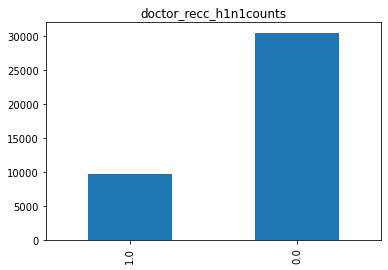

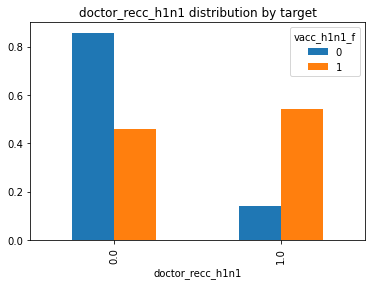

In [1529]:
EDA_plot1(df,'doctor_recc_h1n1')

In [1530]:
type_feature['doctor_recc_h1n1'] = 'bool'

- Note : boolean, significant difference

##### doctor_recc_seasonal

- Description : Seasonal flu vaccine was recommended by doctor.

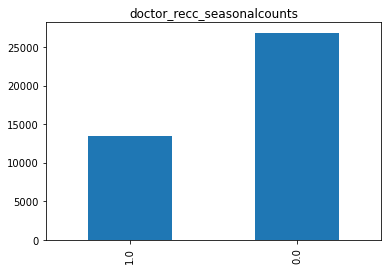

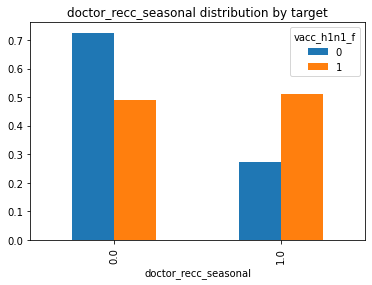

In [1531]:
EDA_plot1(df,'doctor_recc_seasonal')

- Note : boolean, seasonal, significant difference

In [1532]:
type_feature['doctor_recc_seasonal'] = 'bool'

##### chronic_med_condition

- Description : Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. 

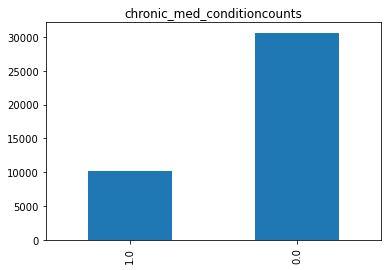

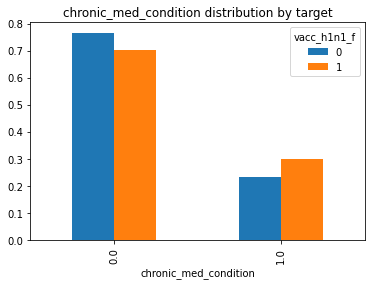

In [1533]:
EDA_plot1(df,'chronic_med_condition')

- Note : boolean

In [1534]:
type_feature['chronic_med_condition'] = 'bool'

##### child_under_6_months

- Description : Has regular close contact with a child under the age of six months.

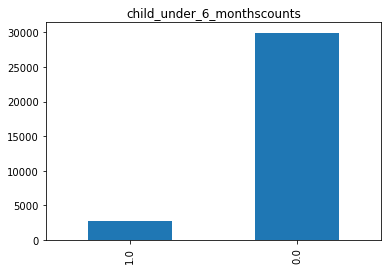

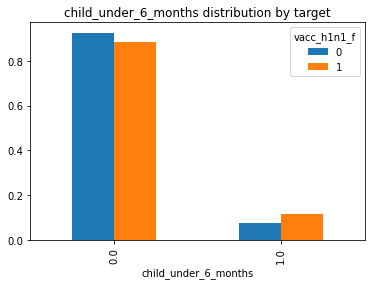

In [1535]:
EDA_plot1(df,'child_under_6_months')

- Note : boolean

In [1536]:
type_feature['child_under_6_months'] = 'bool'

##### health_insurance

- Description : Has health insurance.

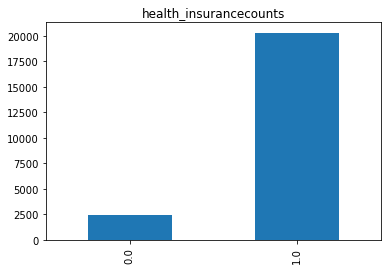

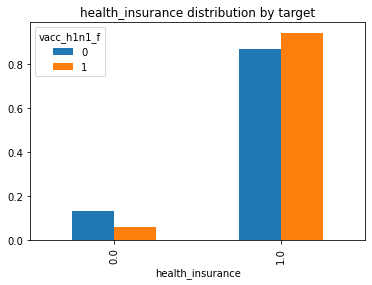

In [1537]:
EDA_plot1(df,'health_insurance')

- Note : boolean

In [1538]:
type_feature['health_insurance'] = 'bool'

##### health_worker

- Description : Is a healthcare worker.

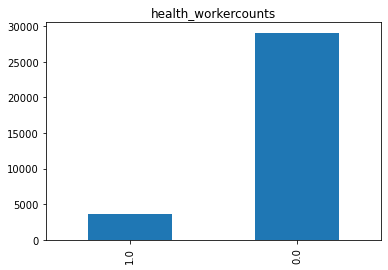

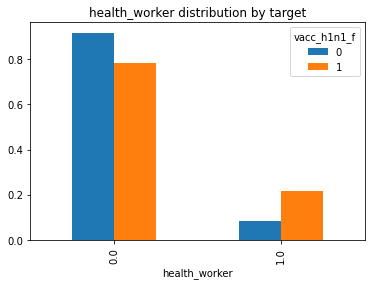

In [1539]:
EDA_plot1(df,'health_worker')

- Note : boolean

In [1540]:
type_feature['health_worker'] = 'bool'

##### opinion_h1n1_vacc_effective

- Description : Respondent's opinion about H1N1 vaccine effectiveness.   

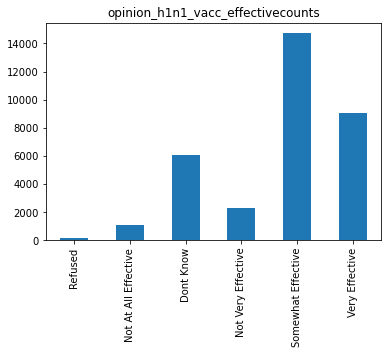

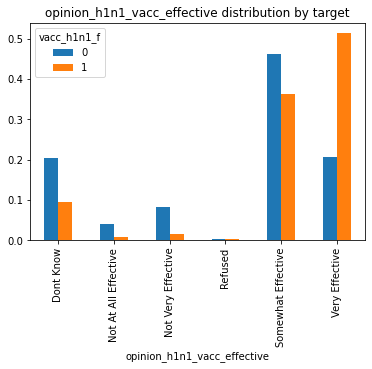

In [1541]:
EDA_plot1(df,'opinion_h1n1_vacc_effective')

- Note : Disordered

In [1542]:
type_feature['opinion_h1n1_vacc_effective'] = 'nominal'

##### opinion_h1n1_risk

- Description : Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.  

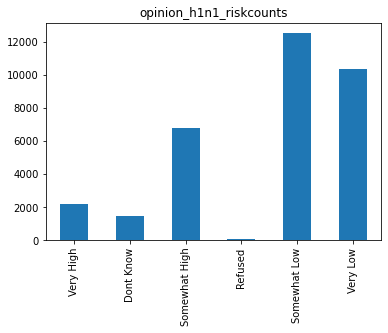

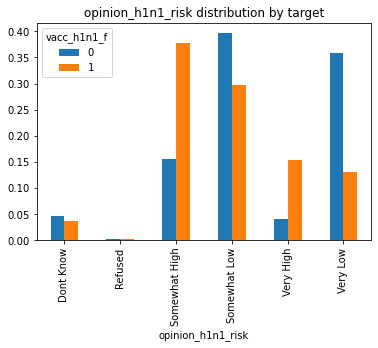

In [1543]:
EDA_plot1(df,'opinion_h1n1_risk')

- Note : ordinal type, dont know/refused -> 3

In [1544]:
type_feature['opinion_h1n1_risk'] = 'nominal' # change later

##### opinion_h1n1_sick_from_vacc

- Description : Respondent's worry of getting sick from taking H1N1 vaccine.   

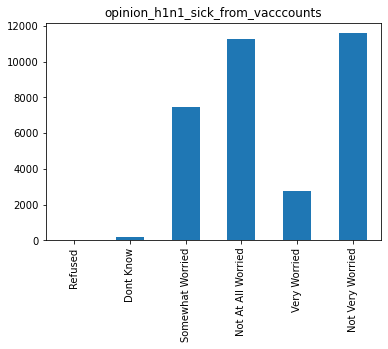

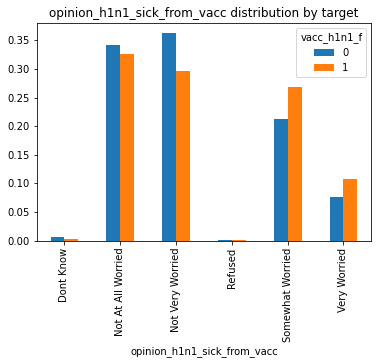

In [1545]:
EDA_plot1(df,'opinion_h1n1_sick_from_vacc')

- Note : ordinal but category integration needed

In [1546]:
type_feature['opinion_h1n1_sick_from_vacc'] = 'nominal'

##### opinion_seas_vacc_effective

- Description : Respondent's opinion about seasonal flu vaccine effectiveness.   

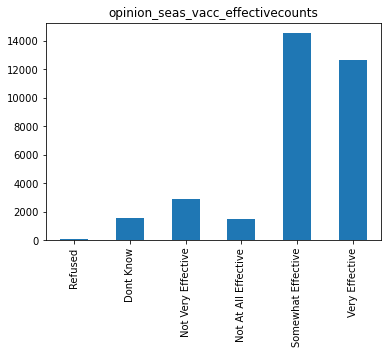

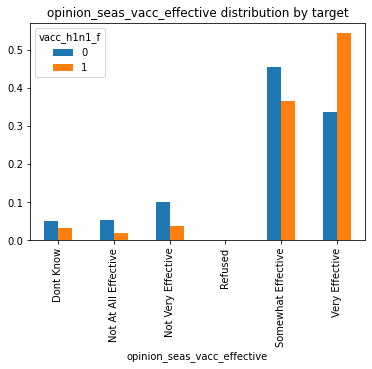

In [1547]:
EDA_plot1(df,'opinion_seas_vacc_effective')

- Note : ordinal but category integration needed

In [1548]:
type_feature['opinion_seas_vacc_effective'] = 'nominal'

##### opinion_seas_risk

- Description : Respondent's opinion about risk of getting sick with seasonal flu without vaccine.   

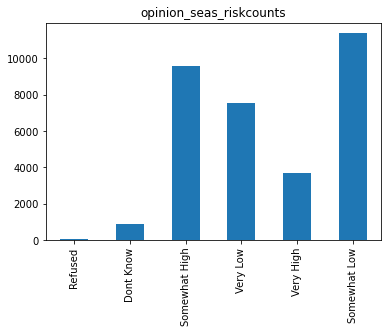

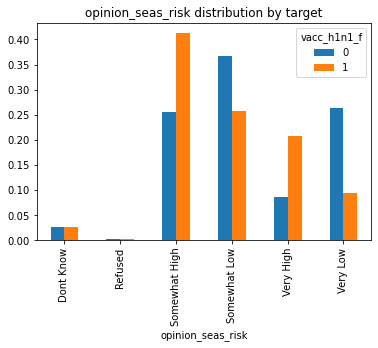

In [1549]:
EDA_plot1(df,'opinion_seas_risk')

- Note : ordinal type, Don't Know/Refused -> 3, seasonal

In [1550]:
type_feature['opinion_seas_risk'] = 'nominal' # change later

##### opinion_seas_sick_from_vacc

- Description : Respondent's worry of getting sick from taking seasonal flu vaccine.  

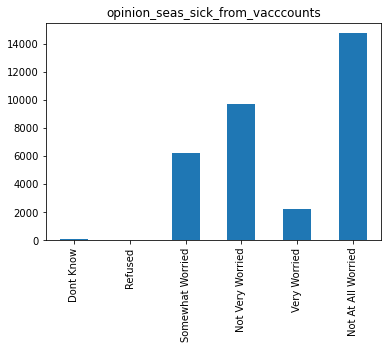

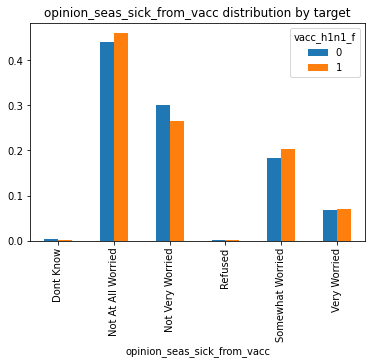

In [1551]:
EDA_plot1(df,'opinion_seas_sick_from_vacc')

- Note : disorder, insignificant

In [1552]:
type_feature['opinion_seas_sick_from_vacc'] = 'nominal'

##### agegrp

- Description : Age group of respondent.   

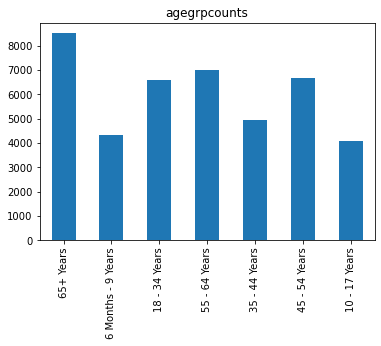

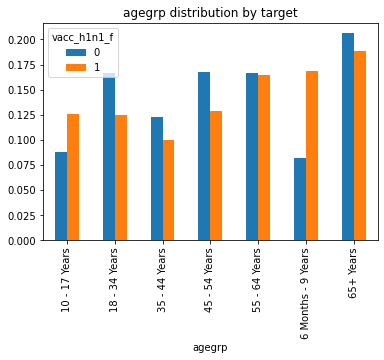

In [1553]:
EDA_plot1(df,'agegrp')

- Note : ordinal type

In [1554]:
df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
df['agegrp'].replace('10 - 17 Years',2,inplace=True)
df['agegrp'].replace('18 - 34 Years',3,inplace=True)
df['agegrp'].replace('35 - 44 Years',4,inplace=True)
df['agegrp'].replace('45 - 54 Years',5,inplace=True)
df['agegrp'].replace('55 - 64 Years',6,inplace=True)
df['agegrp'].replace('65+ Years',7,inplace=True)
type_feature['agegrp'] = 'ordinal'

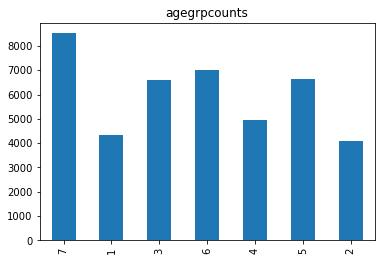

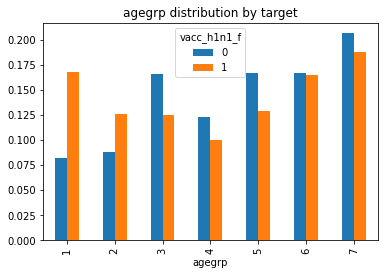

In [1555]:
EDA_plot1(df,'agegrp')

- whether one is student or not is significant

##### education_comp

- Description : Self-reported education level.   
1 = < 12 Years; 2 = 12 Years; 3 = Some College; 4 = College Graduate   

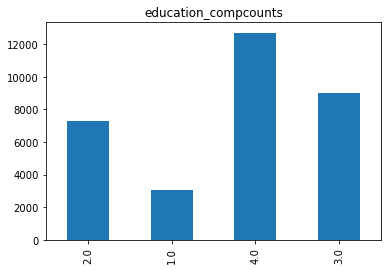

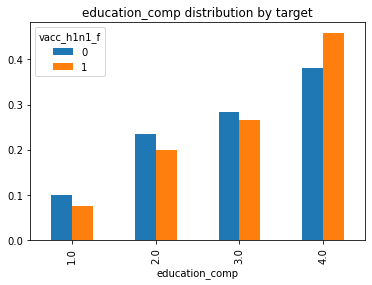

In [1556]:
EDA_plot1(df,'education_comp')

- Note : disorder

In [1557]:
type_feature['education_comp'] = 'nominal'

##### raceeth4_i

- Description : Race of respondent.   
1 = Hispanic; 2 = Non-Hispanic, Black Only; 3 = Non-Hispanic, White Only; 4 = Non-Hispanic, Other or Multiple Races   

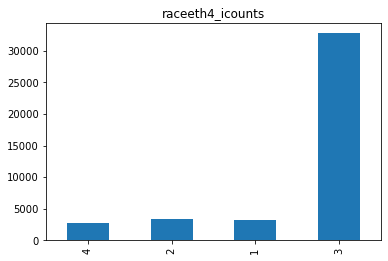

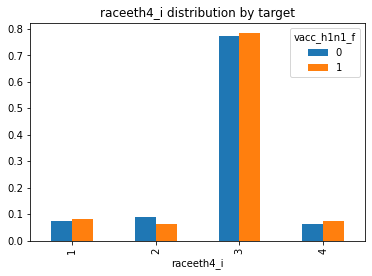

In [1558]:
EDA_plot1(df,'raceeth4_i')

- Note : categorical type

In [1559]:
df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
type_feature['raceeth4_i'] = 'nominal'

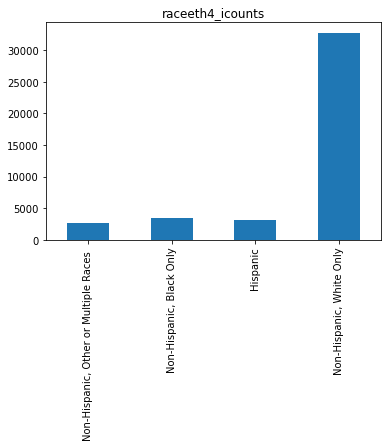

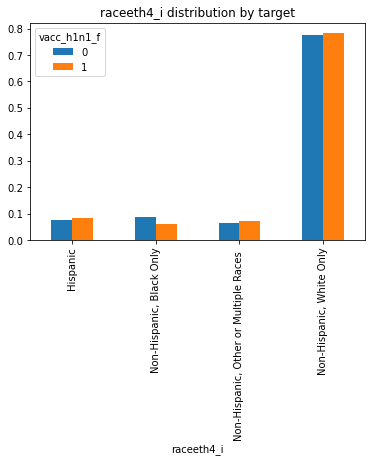

In [1560]:
EDA_plot1(df,'raceeth4_i')

- Note : black or not

##### sex_i

- Description : Sex of respondent.   
1 = Male; 2 = Female   

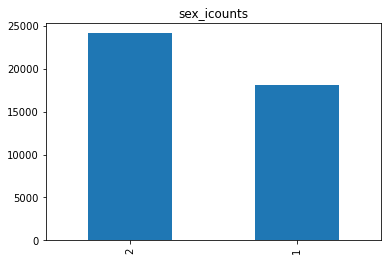

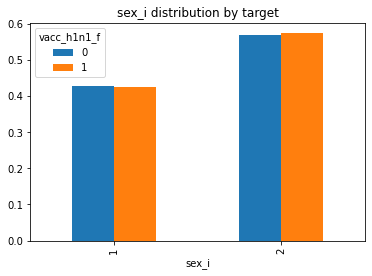

In [1561]:
EDA_plot1(df,'sex_i')

- Note : boolean, Male=True, Female=False

In [1562]:
df['sex_i'].replace(2,0,inplace=True)
type_feature['sex_i'] = 'bool'

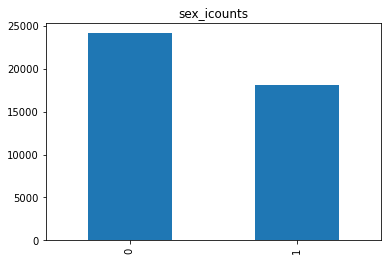

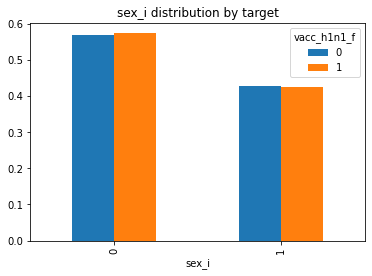

In [1563]:
EDA_plot1(df,'sex_i')

- Note : insignificant

##### inc_pov

- Description : Household annual income of respondent with respect to 2008 Census poverty thresholds.   
1 : > $75,000; 2 : <= $75,000; 3 : Below Poverty; 4 : Unknown   

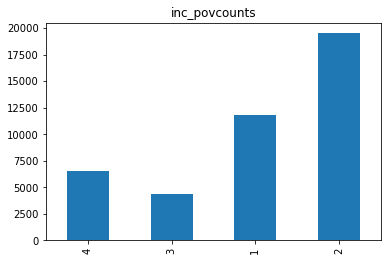

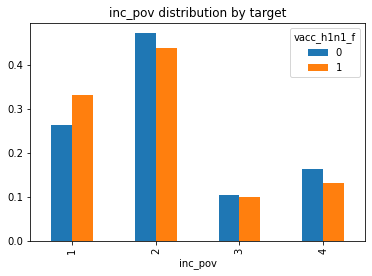

In [1564]:
EDA_plot1(df,'inc_pov')

- Note : ordered categorical type, 4(Unknown) -> np.nan, 3(Below Poverty) -> 1, 1(>=$7500) -> 3

In [1565]:
df['inc_pov'].replace(4,np.nan,inplace=True)
df['inc_pov'].replace(3,5,inplace=True)
df['inc_pov'].replace(1,3,inplace=True)
df['inc_pov'].replace(5,1,inplace=True)

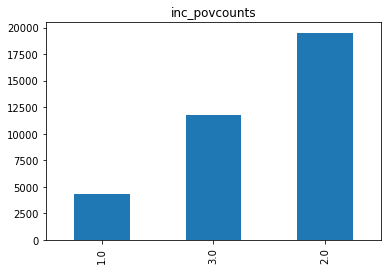

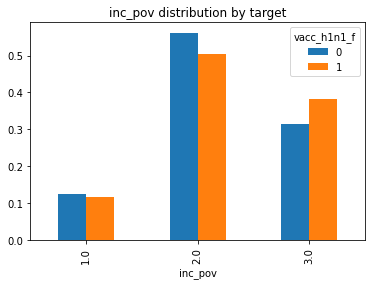

In [1566]:
EDA_plot1(df,'inc_pov')

- Note : disorder

In [1567]:
type_feature['inc_pov'] = 'nominal'

##### marital

- Description : Marital status of respondent.   
1 = Married; 2 = Not Married   

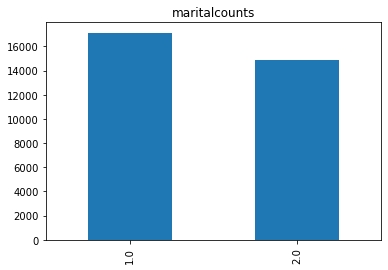

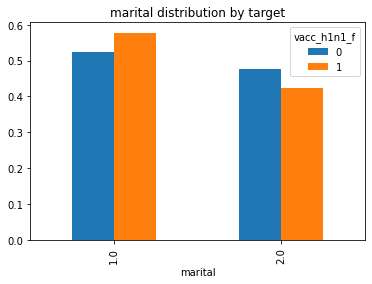

In [1568]:
EDA_plot1(df,'marital')

- Note : boolean

In [1569]:
df['marital'].replace(2,0,inplace=True)
type_feature['marital'] = 'bool'

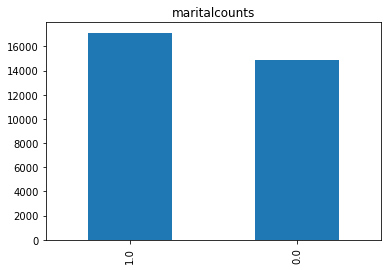

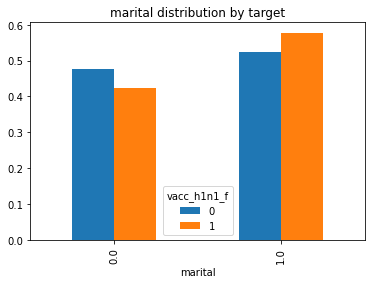

In [1570]:
EDA_plot1(df,'marital')

##### rent_own_r

- Description : Housing situation of respondent.   
1 = Home is Owned; 2 = Home is Rented or Other Arrangement   

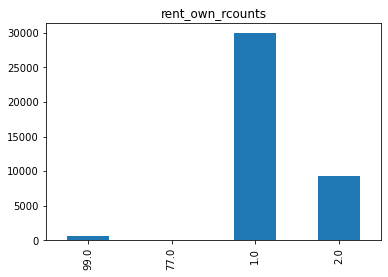

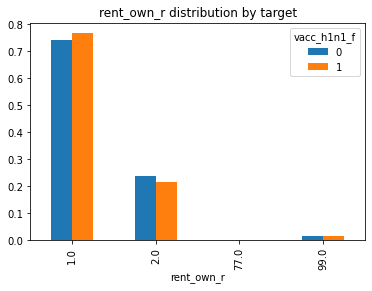

In [1571]:
EDA_plot1(df,'rent_own_r')

- Note : boolean, Outliers(77,99 -> np.nan)

In [1572]:
df['rent_own_r'].replace(77,np.nan,inplace=True)
df['rent_own_r'].replace(99,np.nan,inplace=True)
df['rent_own_r'].replace(2,0,inplace=True)
type_feature['rent_own_r'] = 'bool'

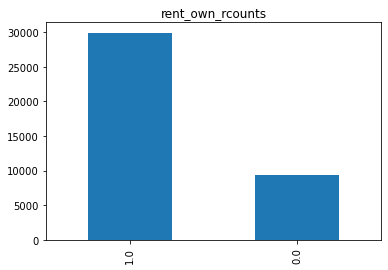

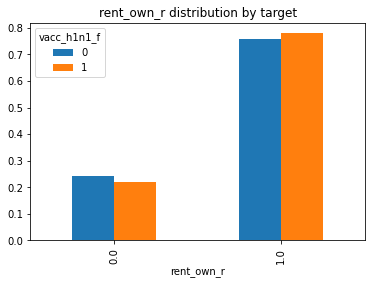

In [1573]:
EDA_plot1(df,'rent_own_r')

##### employment_status

- Description : Employment status of respondent.   

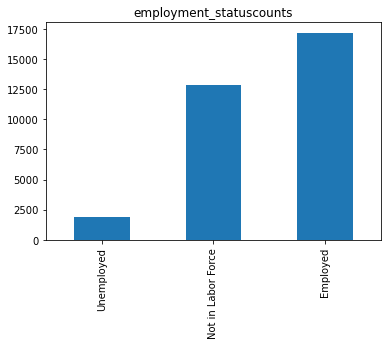

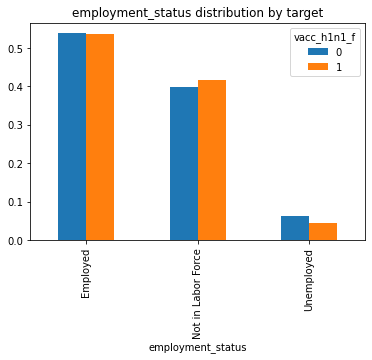

In [1574]:
EDA_plot1(df,'employment_status')

- Note : disorder

In [1575]:
type_feature['employment_status'] = 'nominal'

##### census_region

- Description : True census region of residence   
1=northeast; 2=midwest; 3=south; 4=west   

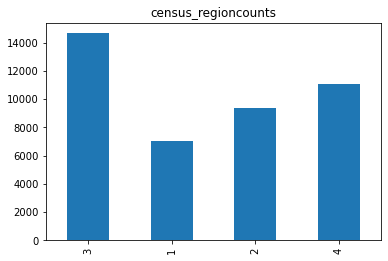

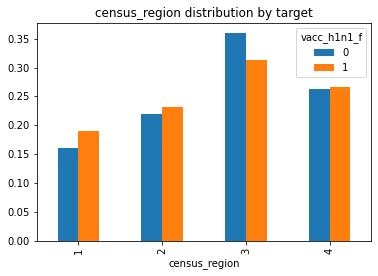

In [1576]:
EDA_plot1(df,'census_region')

- Note : categorical type, location information

In [1577]:
df['census_region'].replace(1,'northeast',inplace=True)
df['census_region'].replace(2,'midwest',inplace=True)
df['census_region'].replace(3,'south',inplace=True)
df['census_region'].replace(4,'west',inplace=True)
type_feature['census_region'] = 'nominal'

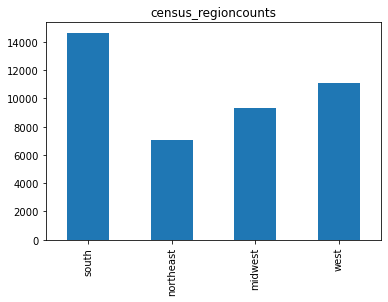

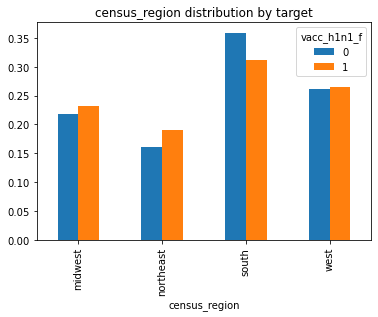

In [1578]:
EDA_plot1(df,'census_region')

##### census_msa

- Description : Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.   

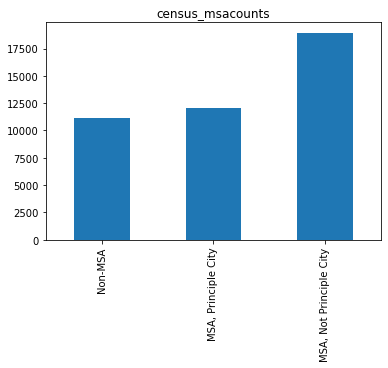

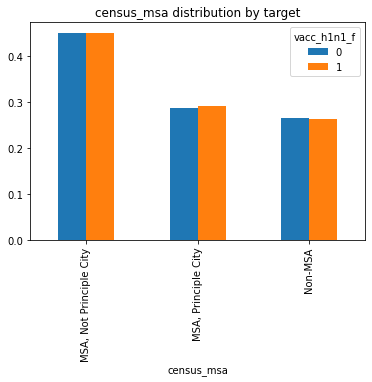

In [1579]:
EDA_plot1(df,'census_msa')

- Note : ordered categorical type, location information

In [1580]:
df['census_msa'].replace('Non-MSA',0,inplace=True)
df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
df['census_msa'].replace('MSA, Principle City',2,inplace=True)
type_feature['census_msa'] = 'ordinal'

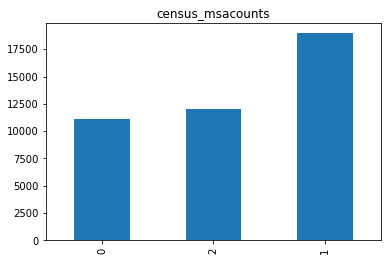

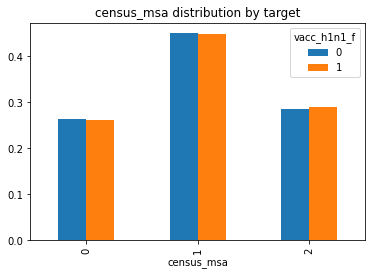

In [1581]:
EDA_plot1(df,'census_msa')

##### n_adult_r

- Description : Number of other adults in household.   

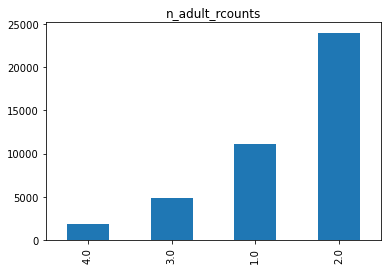

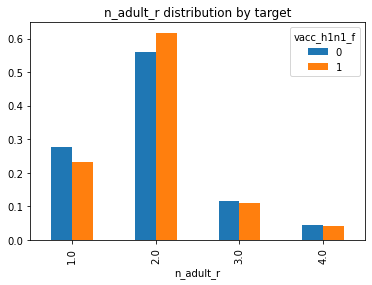

In [1582]:
EDA_plot1(df,'n_adult_r')

- Note : ratio type

In [1583]:
type_feature['n_adult_r'] = 'ratio'

##### household_children

- Description : Number of children in household.   

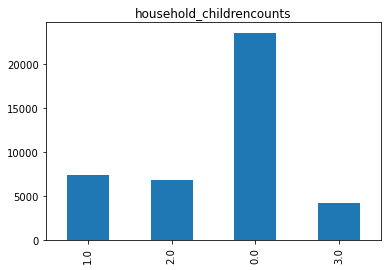

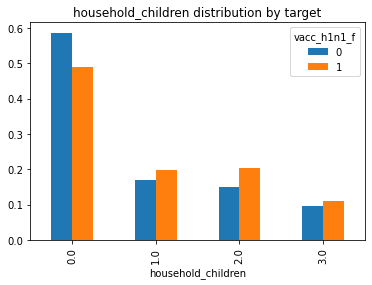

In [1584]:
EDA_plot1(df,'household_children')

- Note : ratio type

In [1585]:
type_feature['household_children'] = 'ratio'

##### n_people_r

- Description : Number of adults in the household.   

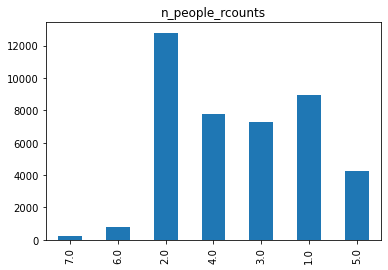

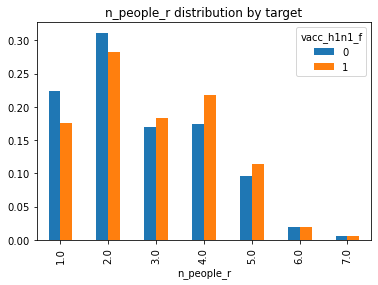

In [1586]:
EDA_plot1(df,'n_people_r')

- Note : ratio type

In [1587]:
type_feature['n_people_r'] = 'ratio'

##### employment_industry

- Description : Type of industry respondent is employed in.   

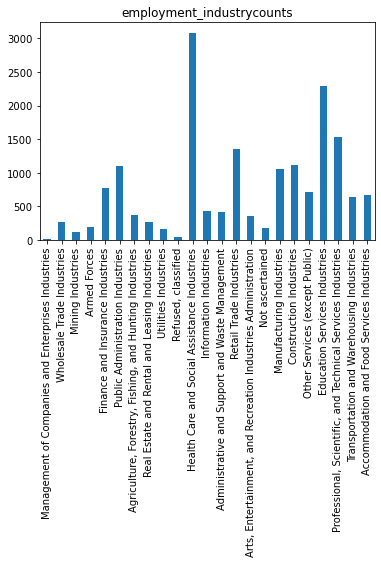

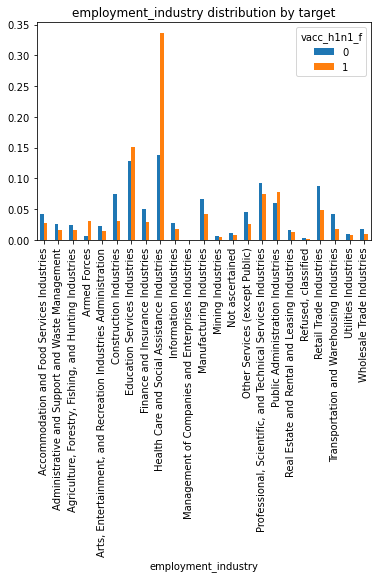

In [1588]:
EDA_plot1(df,'employment_industry')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_occupation

In [1589]:
df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
type_feature['employment_industry'] = 'nominal'

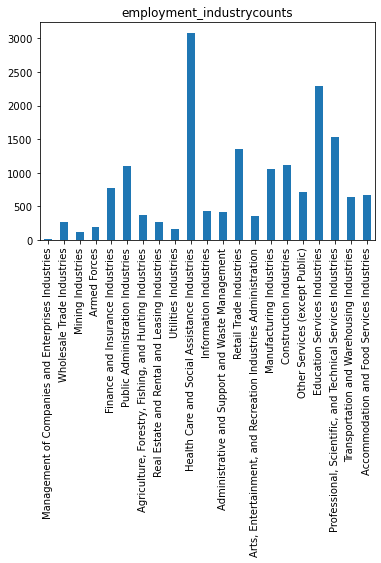

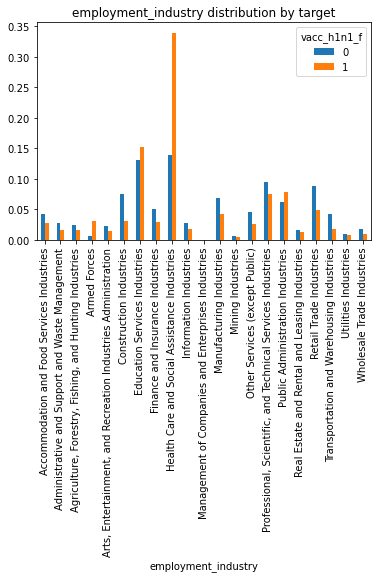

In [1590]:
EDA_plot1(df,'employment_industry')

##### employment_occupation

- Description : Type of occupation of respondent. Values are represented as short random character strings.   

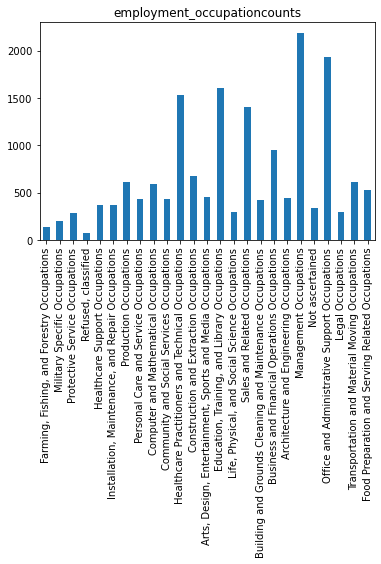

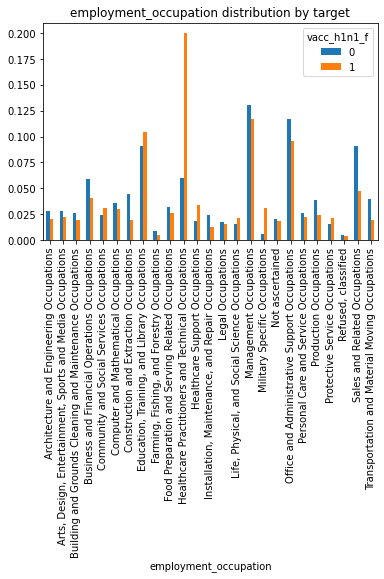

In [1591]:
EDA_plot1(df,'employment_occupation')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_industry

In [1592]:
df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
type_feature['employment_occupation'] = 'nominal'

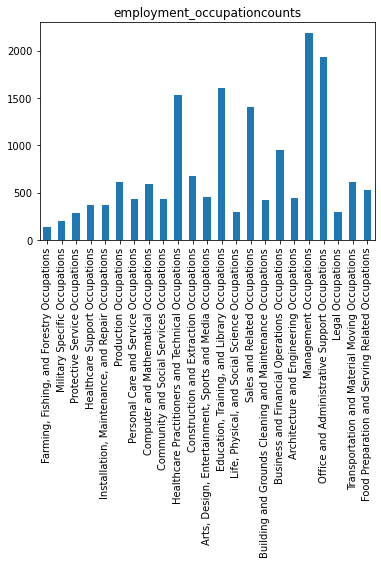

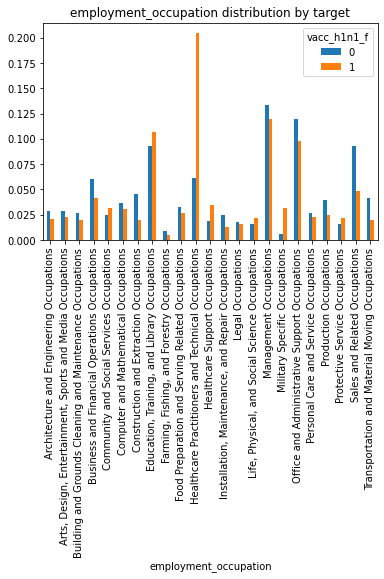

In [1593]:
EDA_plot1(df,'employment_occupation')

##### hhs_region

- Description : HHS surveillance region number   
    - Region 1: CT,ME,MA,NH,RI,VT   
    - Region 2: NJ,NY   
    - Region 3: DE,DC,MD,PA,VA,WV   
    - Region 4: AL,FL,GA,KY,MS,NC,SC,TN   
    - Region 5: IL,IN,MI,MN,OH,WI   
    - Region 6: AR,LA,NM,OK,TX   
    - Region 7: IA,KS,MO,NE   
    - Region 8: CO,MT,ND,SD,UT,WY   
    - Region 9: AZ,CA,HI,NV   
    - Region 10: AK,ID,OR,WA   

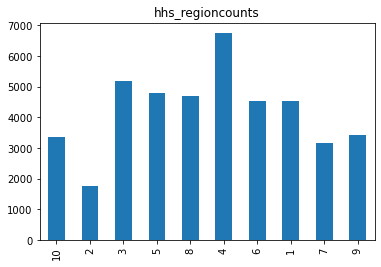

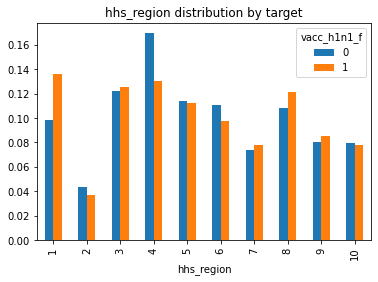

In [1594]:
EDA_plot1(df,'hhs_region')

- Note : categorical type, location information, high cardinality

In [1595]:
df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
type_feature['hhs_region'] = 'nominal'

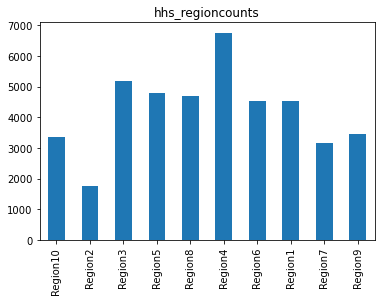

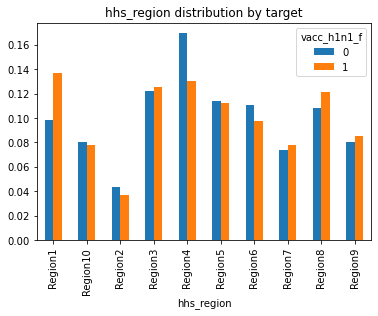

In [1596]:
EDA_plot1(df,'hhs_region')

##### state

- Description : State of residence   

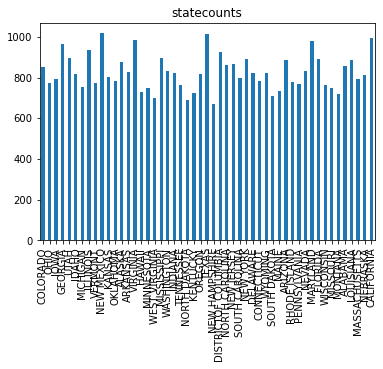

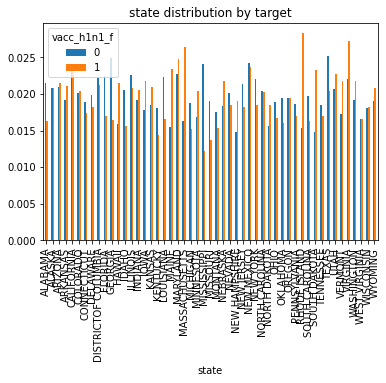

In [1597]:
EDA_plot1(df,'state')

- Note : categorical type, local information, high cardinality

In [1598]:
df['state'].replace('ALABAMA','AL',inplace=True)
df['state'].replace('ALASKA','AK',inplace=True)
df['state'].replace('ARIZONA','AZ',inplace=True)
df['state'].replace('ARKANSAS','AR',inplace=True)
df['state'].replace('CALIFORNIA','CA',inplace=True)
df['state'].replace('COLORADO','CO',inplace=True)
df['state'].replace('CONNECTICUT','CT',inplace=True)
df['state'].replace('DELAWARE','DE',inplace=True)
df['state'].replace('DISTRICTOF COLUMBIA','DC',inplace=True)
df['state'].replace('FLORIDA','FL',inplace=True)
df['state'].replace('GEORGIA','GA',inplace=True)
df['state'].replace('HAWAII','HI',inplace=True)
df['state'].replace('IDAHO','ID',inplace=True)
df['state'].replace('ILLINOIS','IL',inplace=True)
df['state'].replace('INDIANA','IN',inplace=True)
df['state'].replace('IOWA','IA',inplace=True)
df['state'].replace('KANSAS','KS',inplace=True)
df['state'].replace('KENTUCKY','KY',inplace=True)
df['state'].replace('LOUISIANA','LA',inplace=True)
df['state'].replace('MAINE','ME',inplace=True)
df['state'].replace('MARYLAND','MD',inplace=True)
df['state'].replace('MASSACHUSETTS','MA',inplace=True)
df['state'].replace('MICHIGAN','MI',inplace=True)
df['state'].replace('MINNESOTA','MN',inplace=True)
df['state'].replace('MISSISSIPPI','MS',inplace=True)
df['state'].replace('MISSOURI','MO',inplace=True)
df['state'].replace('MONTANA','MT',inplace=True)
df['state'].replace('NEBRASKA','NE',inplace=True)
df['state'].replace('NEVADA','NV',inplace=True)
df['state'].replace('NEW HAMPSHIRE','NH',inplace=True)
df['state'].replace('NEW JERSEY','NJ',inplace=True)
df['state'].replace('NEW MEXICO','NM',inplace=True)
df['state'].replace('NEW YORK','NY',inplace=True)
df['state'].replace('NORTH CAROLINA','NC',inplace=True)
df['state'].replace('NORTH DAKOTA','ND',inplace=True)
df['state'].replace('OHIO','OH',inplace=True)
df['state'].replace('OKLAHOMA','OK',inplace=True)
df['state'].replace('OREGON','OR',inplace=True)
df['state'].replace('PENNSYLVANIA','PA',inplace=True)
df['state'].replace('RHODE ISLAND','RI',inplace=True)
df['state'].replace('SOUTH CAROLINA','SC',inplace=True)
df['state'].replace('SOUTH DAKOTA','SD',inplace=True)
df['state'].replace('TENNESSEE','TN',inplace=True)
df['state'].replace('TEXAS','TX',inplace=True)
df['state'].replace('UTAH','UT',inplace=True)
df['state'].replace('VERMONT','VT',inplace=True)
df['state'].replace('VIRGINIA','VA',inplace=True)
df['state'].replace('WASHINGTON','WA',inplace=True)
df['state'].replace('WEST VIRGINIA','WV',inplace=True)
df['state'].replace('WISCONSIN','WI',inplace=True)
df['state'].replace('WYOMING','WY',inplace=True)
type_feature['state'] = 'nominal'

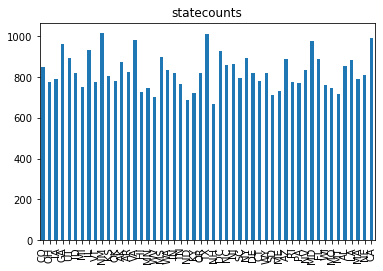

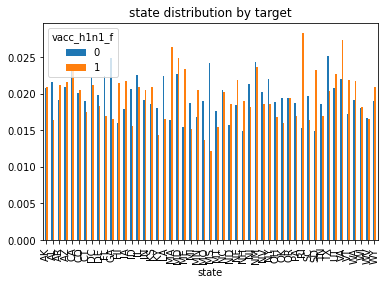

In [1599]:
EDA_plot1(df,'state')

##### map visualization
feature : state, hhs_region, census_region

In [1600]:
import json
import requests
from matplotlib.patches import Polygon
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
dc={"type":"Feature","id":"DC","properties":{"name":"District of Columbia"},"geometry":{"type":"Polygon","coordinates":[[[-77.040741, 38.791222],[-76.909294, 38.895284],[-77.035264, 38.993869],[-77.117418, 38.933623]]]}}
state_geo=dict(json.loads(requests.get(state_geo).text))['features']
state_geo.append(dc)

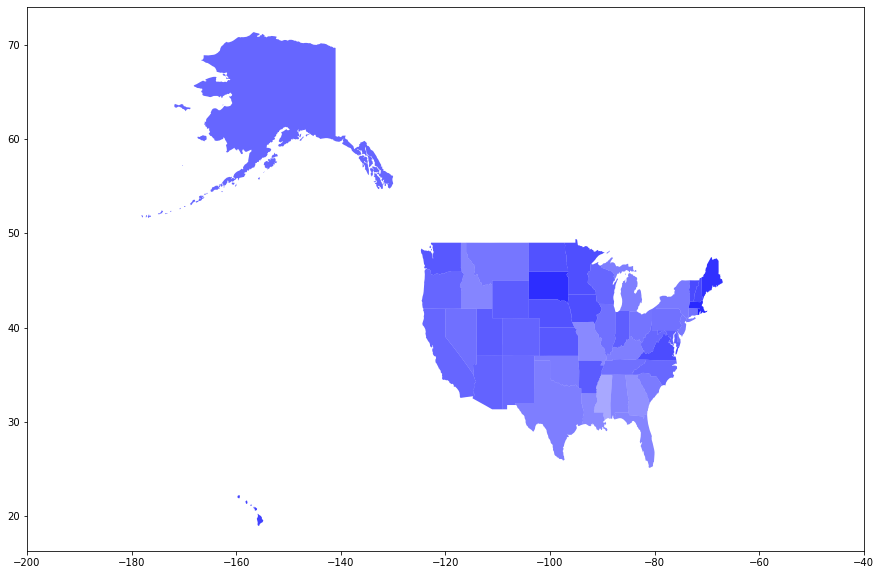

In [1601]:
# vaccine rate group by state
vacc_rate_geo=df[['state','vacc_h1n1_f']].groupby(['state']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_geo.loc[s['id']]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_geo.loc[s['id']]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

In [1602]:
# region relationships, census_msa can't be seperated by state
hhs={}
for i in range(10):
    hhs[f'Region{i+1}']=[]
census={
    'west':[],
    'midwest':[],
    'northeast':[],
    'south':[]
}
for s in df['state'].unique():
    hhs[df[df['state']==s]['hhs_region'].unique()[0]].append(s)
    census[df[df['state']==s]['census_region'].unique()[0]].append(s)
region_dict={}
for s in df['state'].unique():
    region_dict[s]=[df[df['state']==s]['hhs_region'].unique()[0],df[df['state']==s]['census_region'].unique()[0]]

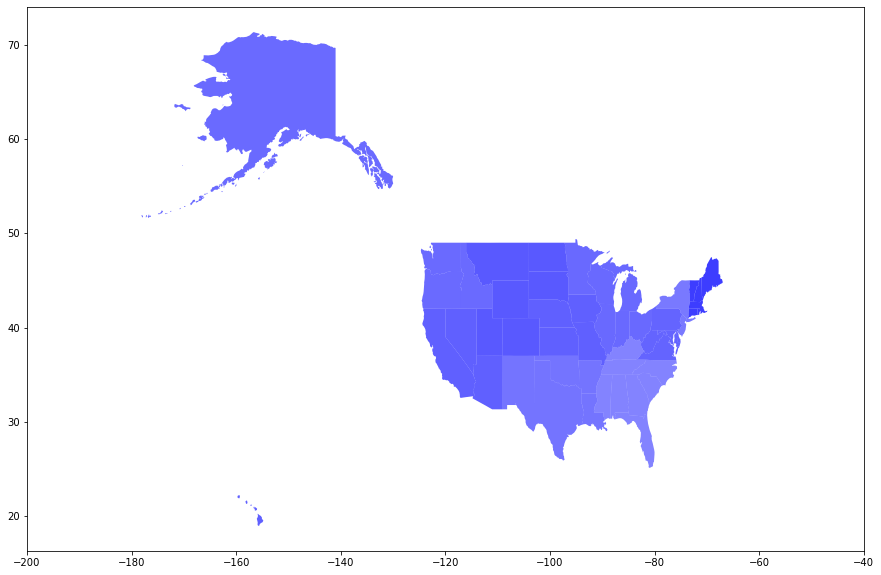

In [1603]:
# vaccine rate group by hhs_region
vacc_rate_hhs=df[['hhs_region','vacc_h1n1_f']].groupby(['hhs_region']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_hhs.loc[region_dict[s['id']][0]]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_hhs.loc[region_dict[s['id']][0]]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

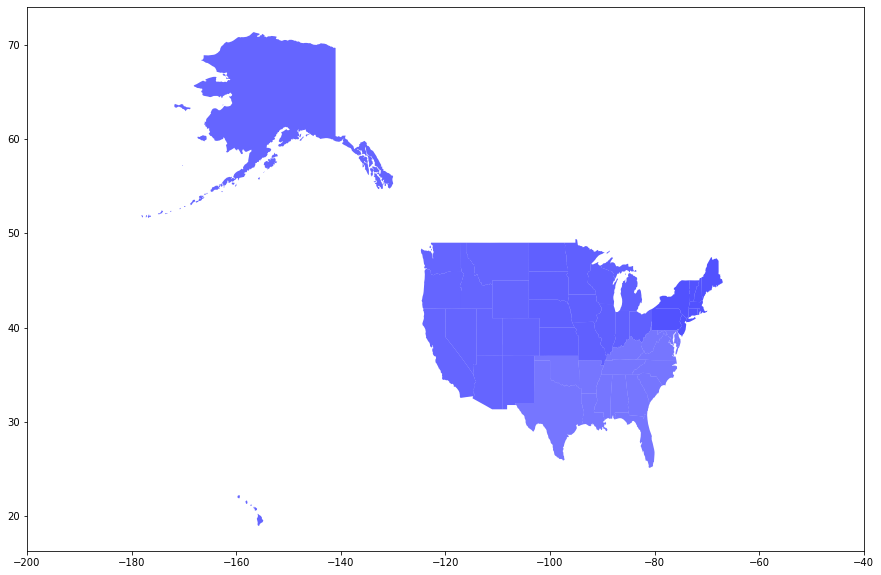

In [1604]:
# vaccine rate group by census_region
vacc_rate_census=df[['census_region','vacc_h1n1_f']].groupby(['census_region']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_census.loc[region_dict[s['id']][1]]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_census.loc[region_dict[s['id']][1]]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

(state, hhs_region, census_region)x(vacc_h1n1_f, ...) more EDA probability

#### Multivariate analysis

##### Missing pattern and Structurally missing data

In [1605]:
#dummy variable of missing values
df_MV=df[:].isna()
df_MV.columns = map(lambda x: x+'_mv',df.columns)
df_MV=df_MV[df_MV.columns[df_MV.sum().map(bool).tolist()]]
df_MV.head()

h1n1_concern_mv  h1n1_knowledge_mv  behavioral_antiviral_meds_mv  \
0             True               True                          True   
1            False              False                         False   
2            False              False                         False   
3            False              False                         False   
4            False              False                         False   

   behavioral_avoidance_mv  behavioral_face_mask_mv  behavioral_wash_hands_mv  \
0                     True                     True                      True   
1                    False                    False                     False   
2                    False                    False                     False   
3                    False                    False                     False   
4                    False                    False                     False   

   behavioral_large_gatherings_mv  behavioral_outside_home_mv  \
0                            True                        True   
1                           False                       False   
2                           False                       False   
3                           False                       False   
4                           False                       False   

   behavioral_touch_face_mv  doctor_recc_h1n1_mv  ...  education_comp_mv  \
0                      True                False  ...               True   
1                     False                False  ...              False   
2                     False                False  ...              False   
3                     False                False  ...              False   
4                     False                False  ...              False   

   inc_pov_mv  marital_mv  rent_own_r_mv  employment_status_mv  n_adult_r_mv  \
0       False        True          False                  True         False   
1       False       False          False                 False         False   
2       False       False          False                 False         False   
3       False       False          False                 False         False   
4       False       False          False                 False         False   

   household_children_mv  n_people_r_mv  employment_industry_mv  \
0                  False          False                    True   
1                  False          False                   False   
2                  False          False                   False   
3                  False          False                   False   
4                  False          False                   False   

   employment_occupation_mv  
0                      True  
1                     False  
2                     False  
3                     False  
4                     False  

[5 rows x 31 columns]

<AxesSubplot:>

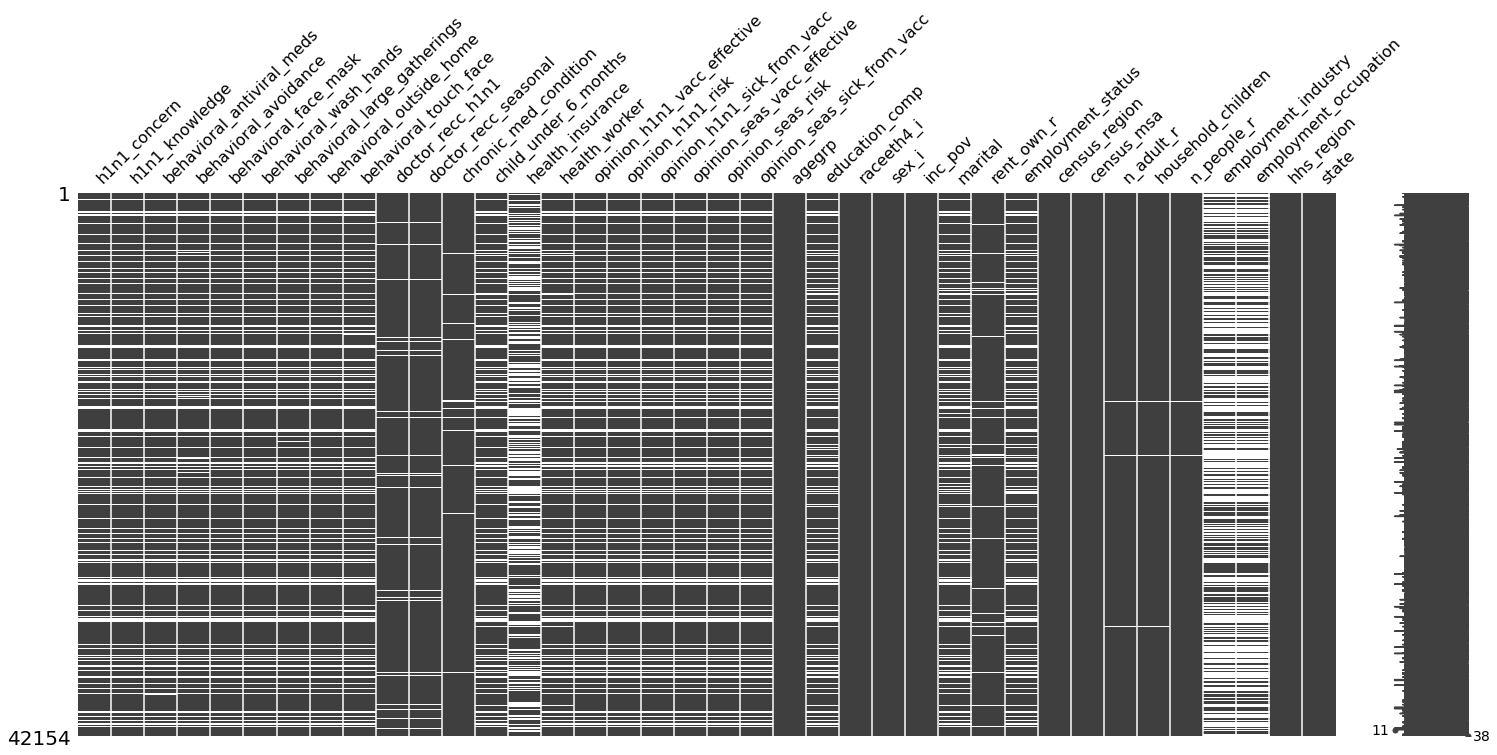

In [1606]:
msno.matrix(train)

<AxesSubplot:>

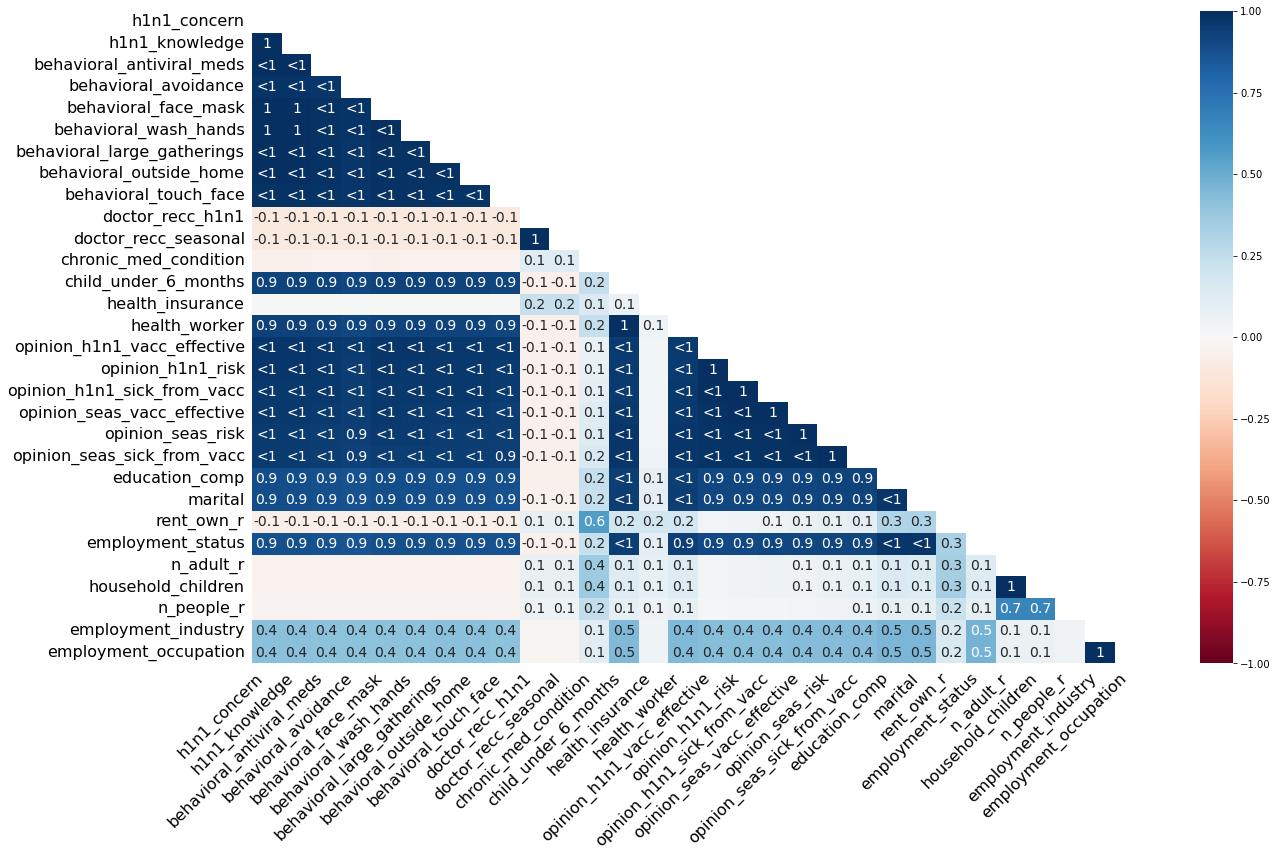

In [1607]:
msno.heatmap(train)

- Missing patterns   
    - pattern_A
        - h1n1_concern
        - h1n1_knowledge
        - behavioral_antiviral_meds
        - behavioral_avoidance
        - behavioral_face_mask
        - behavioral_wash_hands
        - behavioral_large_gatherings
        - behavioral_outside_home
        - behavioral_touch_face
        - child_under_6_months
        - health_worker
        - opinion_h1n1_vacc_effective *
        - opinion_h1n1_risk
        - opinion_h1n1_sick_from_vacc
        - opinion_seas_vacc_effective
        - opinion_seas_risk
        - opinion_seas_sick_from_vacc
        - education_comp
        - marital
        - employment_status
    - pattern_B
        - doctor_recc_h1n1
        - doctor_recc_seasonal
    - pattern_C
        - n_adult_r
        - househole_children
        - n_people_r
    - pattern_D
        - employment_industry
        - employment_occupation

- response rate

In [1608]:
unresponse=df_MV.sum(axis=1)

<AxesSubplot:>

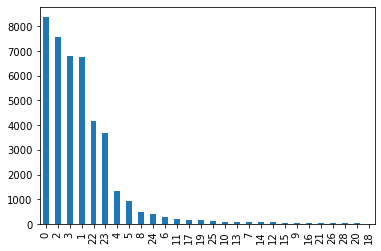

In [1609]:
unresponse.value_counts().plot(kind='bar')

In [1610]:
unresponse = unresponse.map(lambda x: x if x in [0,2,3,1,22,23] else 99)

- Structurally missing data

In [1611]:
#corr 직접 구해야함. corr()메소드는 50개만 구함, 이거따로 바로 위로올라갈지도
df_MV_corr=pd.concat([df,df_MV],axis=1)
df.shape, df_MV.shape, df_MV_corr.shape
#이 방법 말고 structurely missing data 검출가능한가?
# smd는 특정 카테고리가 특정 feature에서 전부 nan값이 떠야함 아니면 대부분?
# 즉 특정 카테고리가 특정 feature에서 전부 nan이 뜨는 경우들 중 smd가 있음.

((42154, 40), (42154, 31), (42154, 71))

In [1612]:
#agegrp에 하기전에 무직 Null값채우기 해야함. 개별분석에서 agegrp이랑 겹치는줄알고 지움
df[df['employment_status']=='Unemployed']['employment_industry'].value_counts()

Series([], Name: employment_industry, dtype: int64)

Filling some MVs with age_group
- 1: '6 Months - 9 Years'
- 2: '10 - 17 Years'
- 3: '18 - 34 Years'
- 4: '35 - 44 Years'
- 5: '45 - 54 Years'
- 6: '55 - 64 Years'
- 7: '65+ Years'


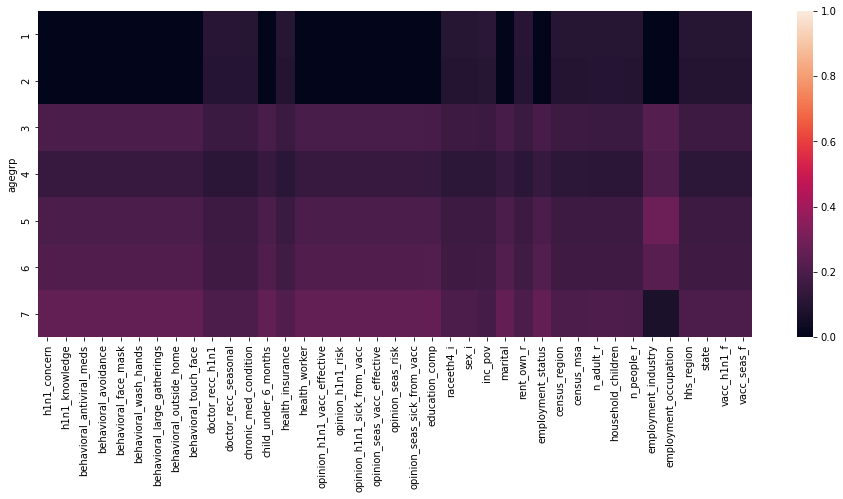

In [1613]:
fig, ax = plt.subplots(figsize=(16,6),nrows=1,ncols=1)
ax=sns.heatmap(df.groupby('agegrp').count().apply(lambda x: x/x.sum()),vmin=0,vmax=1,ax=ax)


In [1614]:
#1,2,7그룹으로 결측치 채우기
df['child_under_6_months']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['child_under_6_months'],axis=1)
df['health_worker']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['health_worker'],axis=1)
df['education_comp']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['education_comp'],axis=1)
df['marital']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['marital'],axis=1)
df['employment_status']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_status'],axis=1)
df['employment_industry']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_industry'],axis=1)
df['employment_occupation']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_occupation'],axis=1)
df['employment_status']=df.apply(lambda x: 'Unemployed' if x['agegrp'] == 7 else x['employment_status'],axis=1)
df['employment_industry']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_industry'],axis=1)
df['employment_occupation']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_occupation'],axis=1)


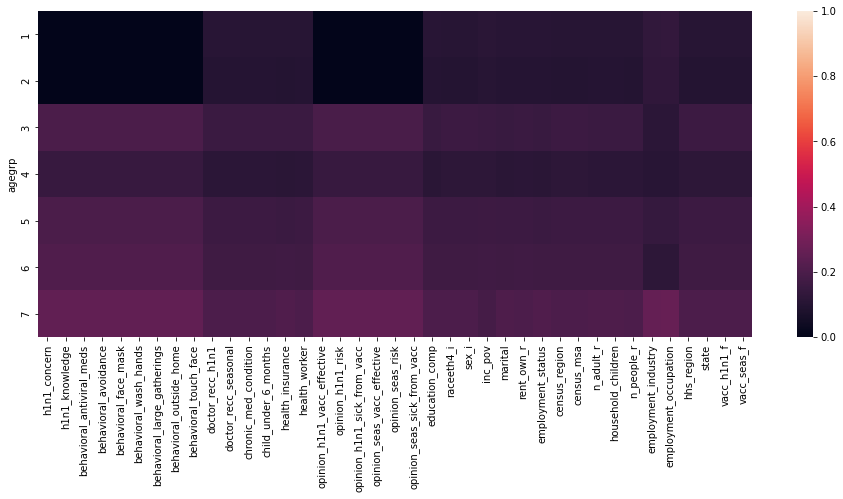

In [1615]:
fig, ax = plt.subplots(figsize=(16,6),nrows=1,ncols=1)
ax=sns.heatmap(df.groupby('agegrp').count().apply(lambda x: x/x.sum()),vmin=0,vmax=1,ax=ax)

<AxesSubplot:>

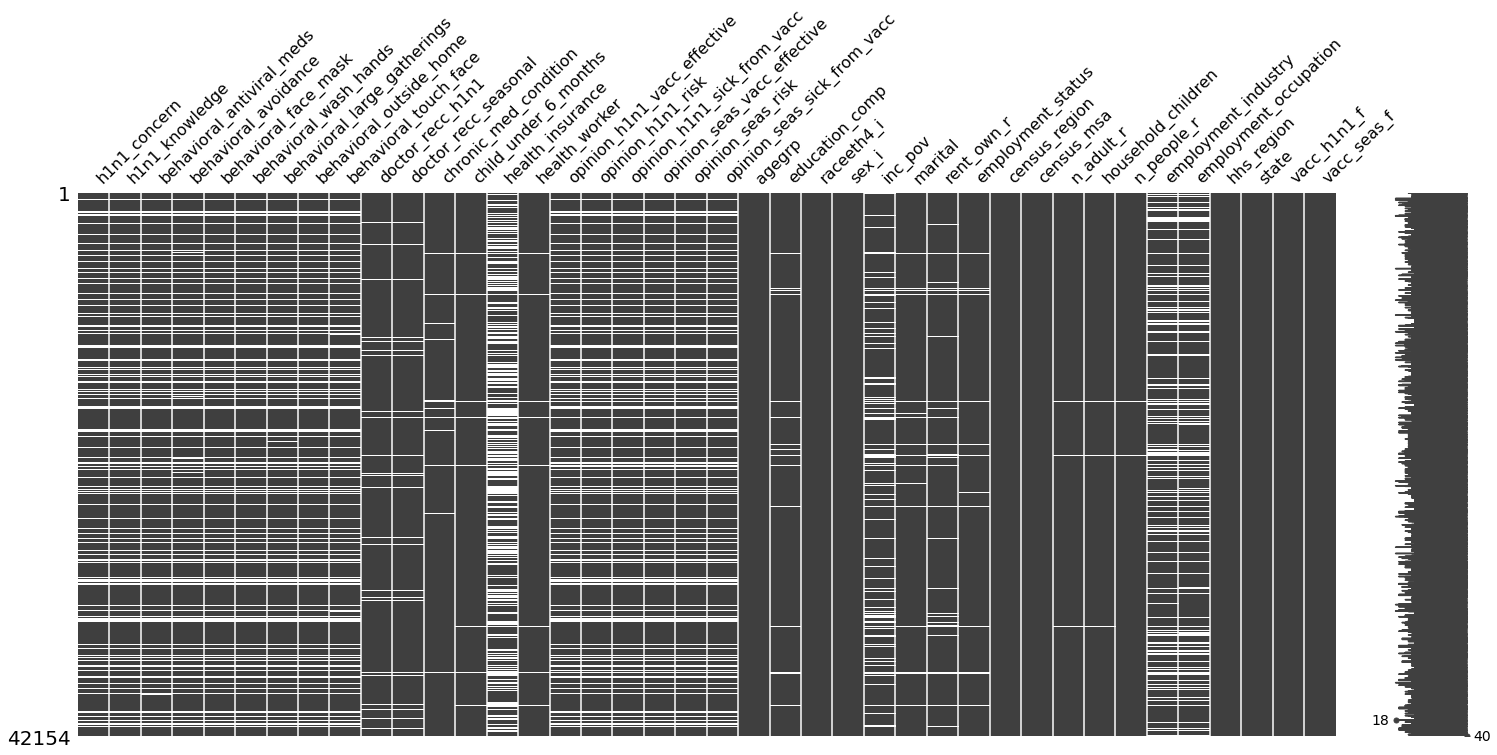

In [1616]:
msno.matrix(df)

In [1617]:
# n_people_r = n_adult_r + household_children
for i in range(len(df)):
    pList=[df['n_people_r'][i], df['n_adult_r'][i], df['household_children'][i]]
    if np.isnan(pList).sum()==1:
        if np.isnan(pList[0]):
            df['n_people_r'][i] = df['n_adult_r'][i] + df['household_children'][i]
        elif np.isnan(pList[1]):
            df['n_adult_r'][i] = df['n_people_r'][i] - df['household_children'][i]
        else:
            df['household_children'][i] = df['n_people_r'][i] - df['n_adult_r'][i]
            

MCAR

In [1618]:
# feature - MV_dummy_feature chi2 test
# H0 : they are independent.
# Ha : they are not independent.
# p<0.05 : dismiss H0 and select Ha.
# p>0.05 : don't know.
# p<0.05 for at least 1 featrue : It is related to some features so it is not MCAR.
# p>0.05 for all features : It can be MCAR. more analysis needed. store at suspect.
suspect=[]
for i in df_MV.columns:
    molu=True
    if df_MV[i].sum()==0:
        print(f'there is no MV in {i}')
        continue
    for j in df.columns:
        obs=pd.crosstab(df_MV[i],df[j])
        p=scipy.stats.chi2_contingency(obs)[1]
        if p<0.05 :
            print(f'{i} is not MCAR')
            molu=False
            break
    if molu:
        print(f'{i} can be MCAR')
        suspect.append(i)


h1n1_concern_mv is not MCAR
h1n1_knowledge_mv is not MCAR
behavioral_antiviral_meds_mv is not MCAR
behavioral_avoidance_mv is not MCAR
behavioral_face_mask_mv is not MCAR
behavioral_wash_hands_mv is not MCAR
behavioral_large_gatherings_mv is not MCAR
behavioral_outside_home_mv is not MCAR
behavioral_touch_face_mv is not MCAR
doctor_recc_h1n1_mv is not MCAR
doctor_recc_seasonal_mv is not MCAR
chronic_med_condition_mv is not MCAR
child_under_6_months_mv is not MCAR
health_insurance_mv is not MCAR
health_worker_mv is not MCAR
opinion_h1n1_vacc_effective_mv is not MCAR
opinion_h1n1_risk_mv is not MCAR
opinion_h1n1_sick_from_vacc_mv is not MCAR
opinion_seas_vacc_effective_mv is not MCAR
opinion_seas_risk_mv is not MCAR
opinion_seas_sick_from_vacc_mv is not MCAR
education_comp_mv is not MCAR
inc_pov_mv is not MCAR
marital_mv is not MCAR
rent_own_r_mv is not MCAR
employment_status_mv is not MCAR
n_adult_r_mv is not MCAR
household_children_mv is not MCAR
n_people_r_mv is not MCAR
employment_in

In [1619]:
print(suspect)

[]


##### Test of Independence

In [1620]:
# nominal-nominal : chi2 and fisher
# bool-ordinal : Mann Whitney U test groupby bool
# nominal-ordinal : Kruskal–Wallis groupby nominal
# ordinal-ordinal : Mann Whitney U test

for i in itertools.combinations(df.columns,2):
    if not set(i)-set(('nominal','bool')):
        obs=pd.crosstab(df[i[0]],df[i[1]])
        obsl=list(itertools.chain.from_iterable(np.array(obs)))
        l=len(obsl)
        a=len(list(itertools.filterfalse(lambda x: x<5,map(lambda x: x[0]*x[1]/sum(obsl),itertools.permutations(obsl,2)))))
        if a<l/5: # fisher
            if l==4:
                p=scipy.stats.fisher_exact(obs)
                if p<0.05:
                    print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')
        else: # chi2
            p=scipy.stats.chi2_contingency(obs,correction=False)[1]
            if p<0.05:
                print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')

    elif not set(i)-set(('ordinal','interval')): # 
        p=scipy.stats.mannwhitneyu(i[0],i[1])
        if p[1]<0.05:
            print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')
    elif set(i)==set(('bool','interval')) or set(i)==set(('bool','ordinal')):
        if i[0]=='bool':
            a=df[df[i[0]]==1]
            b=df[df[i[0]]==0]
        else:
            a=df[df[i[1]]==1]
            b=df[df[i[1]]==0]
        p=scipy.stats.mannwhitneyu(a,b)
        if p[1]<0.05:
            print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')
    else:
        catlist=[]
        if i[0]=='nominal':
            for cat in df[i[0]].unique():
                catlist.append(df[df[i[0]]==cat][i[1]])
        else:
            for cat in df[i[1]].unique():
                catlist.append(df[df[i[1]]==cat][i[0]])
        p=scipy.stats.kruskal(*catlist)
        if p[1]<0.05:
            print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')

TypeError: unsupported format string passed to KruskalResult.__format__

##### Correlation

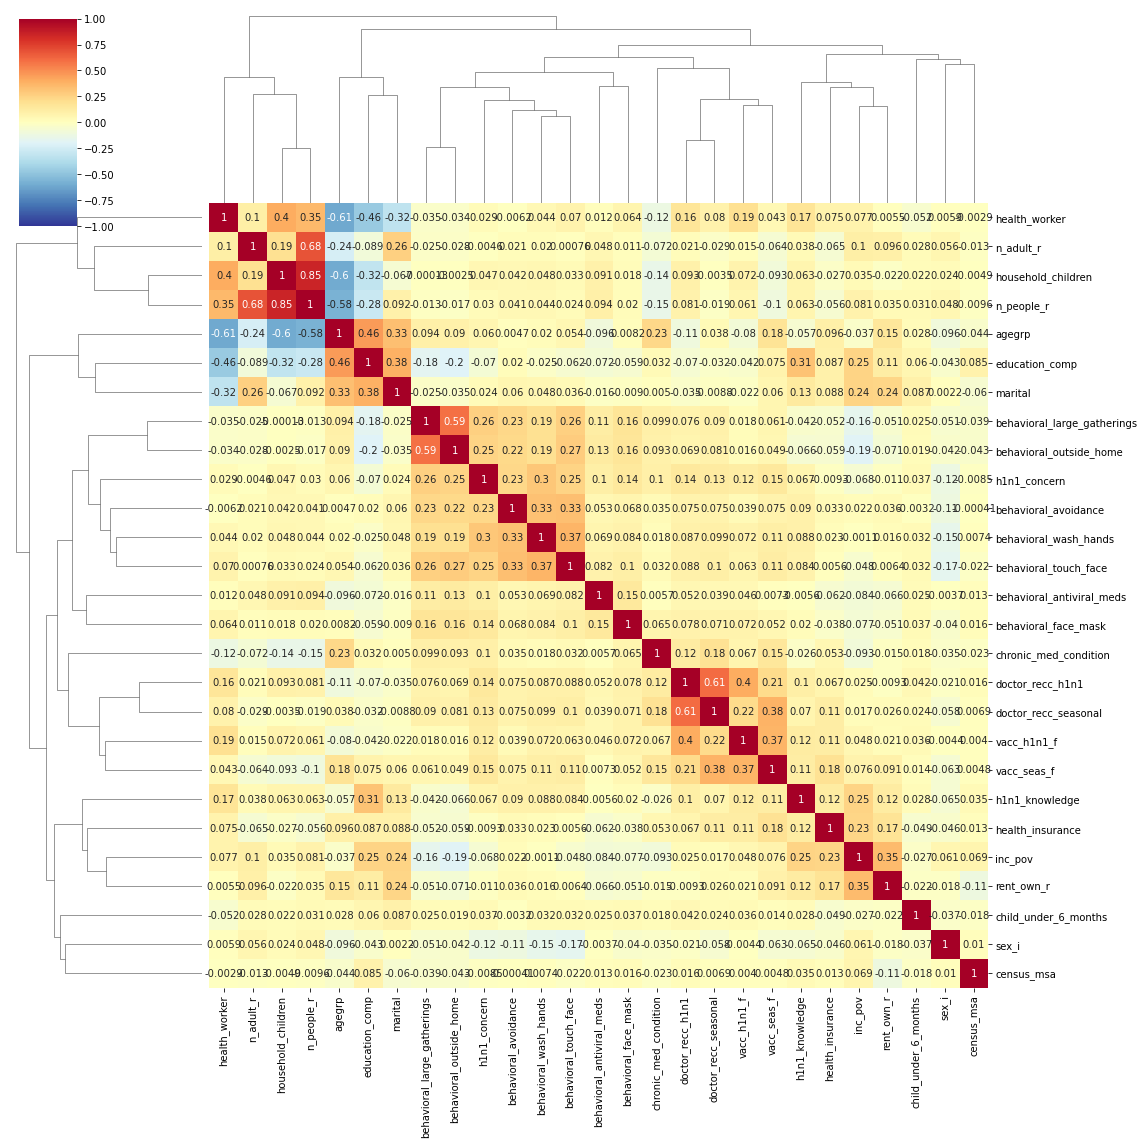

In [ ]:
corr = df.corr(method='pearson')
sns.clustermap(corr, 
            annot = True,      # 실제 값 화면에 나타내기
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
            vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
            figsize=(16,16)
            )

Note : household_children, n_people_r are correlated but

In [ ]:
# n_adult_r + household_children = n_people_r
for i in range(len(df)):
    if np.isnan(df['n_adult_r'][i]) or np.isnan(df['household_children'][i]) or np.isnan(df['n_people_r'][i]):
        continue
    if df['n_adult_r'][i]+df['household_children'][i]!=df['n_people_r'][i]:
        print(f"{df['n_adult_r'][i]},{df['household_children'][i]},{df['n_people_r'][i]}")

##### Clustering

In [ ]:
!pip install kpod

In [ ]:
# one-hot encoder
def encoder(df,type_feature_temp):
    encode_needed = [x for x in df.columns if type_feature_temp[x]=='nominal']
    encoded = pd.get_dummies(df,columns=encode_needed)
    col_list = encoded.columns.tolist()
    for i in range(len(col_list)):
        col_list[i] = col_list[i].replace(',','_')
        col_list[i] = col_list[i].replace(' ','_')
    encoded.columns = col_list
    return encoded

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# X shoudl be a numpy matrix, very likely sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix
# T1 > T2 for overlapping clusters
# T1 = Distance to centroid point to not include in other clusters
# T2 = Distance to centroid point to include in cluster
# T1 > T2 for overlapping clusters
# T1 < T2 will have points which reside in no clusters
# T1 == T2 will cause all points to reside in mutually exclusive clusters
# Distance metric can be any from here: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html
# filemap may be a list of point names in their order in X. If included, row numbers from X will be replaced with names from filemap. 
 
def canopy(X, T1, T2, distance_metric='euclidean', filemap=None):
    canopies = dict()
    X1_dist = pairwise_distances(X, metric=distance_metric)
    canopy_points = set(range(X.shape[0]))
    while canopy_points:
        point = canopy_points.pop()
        i = len(canopies)
        canopies[i] = {"c":point, "points": list(np.where(X1_dist[point] < T2)[0])}
        canopy_points = canopy_points.difference(set(np.where(X1_dist[point] < T1)[0]))
    if filemap:
        for canopy_id in canopies.keys():
            canopy = canopies.pop(canopy_id)
            canopy2 = {"c":filemap[canopy['c']], "points":list()}
            for point in canopy['points']:
                canopy2["points"].append(filemap[point])
            canopies[canopy_id] = canopy2
    return canopies

In [ ]:
cnp=canopy(encoder(df[train.columns].dropna(),type_feature),7,4)
print(len(cnp))
print(cnp)

7
{0: {'c': 0, 'points': [0]}, 1: {'c': 2, 'points': [2, 1853, 2603, 3204, 5122, 5216, 6261, 6535, 7087, 7340, 7719, 8006, 8719, 9142, 10605, 10612, 10890, 11108, 11206]}, 2: {'c': 9216, 'points': [9216]}, 3: {'c': 4608, 'points': [1441, 1640, 1649, 2473, 3075, 3410, 4608, 4792, 5655, 5883, 6571, 7158, 8271, 8456, 9208, 9506, 9574, 9790, 10436, 10770]}, 4: {'c': 7808, 'points': [943, 7808]}, 5: {'c': 2624, 'points': [2624]}, 6: {'c': 6352, 'points': [6352]}}


In [ ]:
# import the k_pod method
from kPOD import k_pod

# set the number of clusters desired (in this example, 3)
K = 7

# use previously existing data to perform clustering
clustering_results = k_pod(encoder(df[train.columns],type_feature), K)

# k_pod outputs a tuple with the cluster assignments and centers
print(clustering_results)


# save the cluster assignments and centers
cluster_assignments = clustering_results[0]
cluster_centers = clustering_results[1]

(array([1., 0., 3., ..., 5., 4., 6.]), [array([1.65830996e+00, 3.07995861e-02, 7.22504362e-01, 6.73757501e-02,
       8.23059713e-01, 3.96499807e-01, 3.77441395e-01, 6.90959576e-01,
       2.11185295e-01, 3.76243970e-01, 3.58841557e-01, 6.19610393e-02,
       7.74263133e-01, 8.38733504e-02, 6.26905096e+00, 3.83648901e-01,
       4.55095987e-01, 8.03105663e-01, 9.75338943e-01, 1.53889117e+00,
       2.02407225e-02, 1.55931672e+00, 1.22662459e-01, 5.45348294e-01,
       3.31989247e-01, 2.14936886e-01, 3.10308555e-02, 5.91982235e-02,
       3.91538102e-03, 4.07141187e-01, 2.75303880e-01, 6.03085554e-02,
       3.09724170e-03, 1.84373539e-01, 3.51273960e-01, 5.24777934e-02,
       3.38884993e-01, 9.29172511e-03, 3.55014025e-01, 3.40521272e-01,
       1.46096307e-03, 2.10787751e-01, 7.18793829e-02, 5.93151005e-02,
       3.96797569e-02, 6.66783544e-02, 2.68817204e-03, 3.83239832e-01,
       4.35717625e-01, 3.78681627e-02, 2.57129500e-03, 2.91841982e-01,
       3.11360449e-01, 1.07585320e-01

In [ ]:
(len(df), len(clustering_results[0]))

(41514, 41514)

In [ ]:
# Cluster sampling
split_index = pd.DataFrame(clustering_results[0],columns=['cluster']).reset_index()
train_index = []
test_index = []
validate_index = []
for i in split_index.cluster.unique():
    X_temp,X_test,y_temp,y_test = train_test_split(split_index[split_index.cluster==i],split_index[split_index.cluster==i],test_size=0.2,random_state=42)
    X_train,X_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.2,random_state=42)
    train_index.extend(X_train.index.tolist())
    test_index.extend(X_test.index.tolist())
    validate_index.extend(X_val.index.tolist())
len(train_index), len(test_index), len(validate_index)

(26563, 8306, 6645)

##### Factor analysis

In [ ]:
# skip

##### Functionization

In [ ]:
def EDA(df):
    df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
    df['agegrp'].replace('10 - 17 Years',2,inplace=True)
    df['agegrp'].replace('18 - 34 Years',3,inplace=True)
    df['agegrp'].replace('35 - 44 Years',4,inplace=True)
    df['agegrp'].replace('45 - 54 Years',5,inplace=True)
    df['agegrp'].replace('55 - 64 Years',6,inplace=True)
    df['agegrp'].replace('65+ Years',7,inplace=True)
    df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
    df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
    df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
    df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
    df['sex_i'].replace(2,0,inplace=True)
    df['inc_pov'].replace(4,np.nan,inplace=True)
    df['inc_pov'].replace(3,5,inplace=True)
    df['inc_pov'].replace(1,3,inplace=True)
    df['inc_pov'].replace(5,1,inplace=True)
    df['marital'].replace(2,0,inplace=True)
    df['rent_own_r'].replace(77,np.nan,inplace=True)
    df['rent_own_r'].replace(99,np.nan,inplace=True)
    df['rent_own_r'].replace(2,0,inplace=True)
    df['census_region'].replace(1,'northeast',inplace=True)
    df['census_region'].replace(2,'midwest',inplace=True)
    df['census_region'].replace(3,'south',inplace=True)
    df['census_region'].replace(4,'west',inplace=True)
    df['census_msa'].replace('Non-MSA',0,inplace=True)
    df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
    df['census_msa'].replace('MSA, Principle City',2,inplace=True)
    df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
    df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
    df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
    df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
    df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
    df['state'].replace('ALABAMA','AL',inplace=True)
    df['state'].replace('ALASKA','AK',inplace=True)
    df['state'].replace('ARIZONA','AZ',inplace=True)
    df['state'].replace('ARKANSAS','AR',inplace=True)
    df['state'].replace('CALIFORNIA','CA',inplace=True)
    df['state'].replace('COLORADO','CO',inplace=True)
    df['state'].replace('CONNECTICUT','CT',inplace=True)
    df['state'].replace('DELAWARE','DE',inplace=True)
    df['state'].replace('DISTRICTOF COLUMBIA','DC',inplace=True)
    df['state'].replace('FLORIDA','FL',inplace=True)
    df['state'].replace('GEORGIA','GA',inplace=True)
    df['state'].replace('HAWAII','HI',inplace=True)
    df['state'].replace('IDAHO','ID',inplace=True)
    df['state'].replace('ILLINOIS','IL',inplace=True)
    df['state'].replace('INDIANA','IN',inplace=True)
    df['state'].replace('IOWA','IA',inplace=True)
    df['state'].replace('KANSAS','KS',inplace=True)
    df['state'].replace('KENTUCKY','KY',inplace=True)
    df['state'].replace('LOUISIANA','LA',inplace=True)
    df['state'].replace('MAINE','ME',inplace=True)
    df['state'].replace('MARYLAND','MD',inplace=True)
    df['state'].replace('MASSACHUSETTS','MA',inplace=True)
    df['state'].replace('MICHIGAN','MI',inplace=True)
    df['state'].replace('MINNESOTA','MN',inplace=True)
    df['state'].replace('MISSISSIPPI','MS',inplace=True)
    df['state'].replace('MISSOURI','MO',inplace=True)
    df['state'].replace('MONTANA','MT',inplace=True)
    df['state'].replace('NEBRASKA','NE',inplace=True)
    df['state'].replace('NEVADA','NV',inplace=True)
    df['state'].replace('NEW HAMPSHIRE','NH',inplace=True)
    df['state'].replace('NEW JERSEY','NJ',inplace=True)
    df['state'].replace('NEW MEXICO','NM',inplace=True)
    df['state'].replace('NEW YORK','NY',inplace=True)
    df['state'].replace('NORTH CAROLINA','NC',inplace=True)
    df['state'].replace('NORTH DAKOTA','ND',inplace=True)
    df['state'].replace('OHIO','OH',inplace=True)
    df['state'].replace('OKLAHOMA','OK',inplace=True)
    df['state'].replace('OREGON','OR',inplace=True)
    df['state'].replace('PENNSYLVANIA','PA',inplace=True)
    df['state'].replace('RHODE ISLAND','RI',inplace=True)
    df['state'].replace('SOUTH CAROLINA','SC',inplace=True)
    df['state'].replace('SOUTH DAKOTA','SD',inplace=True)
    df['state'].replace('TENNESSEE','TN',inplace=True)
    df['state'].replace('TEXAS','TX',inplace=True)
    df['state'].replace('UTAH','UT',inplace=True)
    df['state'].replace('VERMONT','VT',inplace=True)
    df['state'].replace('VIRGINIA','VA',inplace=True)
    df['state'].replace('WASHINGTON','WA',inplace=True)
    df['state'].replace('WEST VIRGINIA','WV',inplace=True)
    df['state'].replace('WISCONSIN','WI',inplace=True)
    df['state'].replace('WYOMING','WY',inplace=True)
    df['child_under_6_months']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['child_under_6_months'],axis=1)
    df['health_worker']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['health_worker'],axis=1)
    df['education_comp']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['education_comp'],axis=1)
    df['marital']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['marital'],axis=1)
    df['employment_status']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_status'],axis=1)
    df['employment_industry']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_industry'],axis=1)
    df['employment_occupation']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_occupation'],axis=1)
    df['employment_status']=df.apply(lambda x: 'Unemployed' if x['agegrp'] == 7 else x['employment_status'],axis=1)
    df['employment_industry']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_industry'],axis=1)
    df['employment_occupation']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_occupation'],axis=1)
    for i in range(len(df)):
        pList=[df['n_people_r'][i], df['n_adult_r'][i], df['household_children'][i]]
        if np.isnan(pList).sum()==1:
            if np.isnan(pList[0]):
                df['n_people_r'][i] = df['n_adult_r'][i] + df['household_children'][i]
            elif np.isnan(pList[1]):
                df['n_adult_r'][i] = df['n_people_r'][i] - df['household_children'][i]
            else:
                df['household_children'][i] = df['n_people_r'][i] - df['n_adult_r'][i]
    clear_output()
    return df

## Data Preprocessing

### Duplicates

In [ ]:
train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
target = target['vacc_h1n1_f']
df=pd.concat([train,target],axis=1)

In [ ]:
max_acc = (train.shape[0]-train.duplicated(keep=False).sum())/train.shape[0]*100
print(f'maximum accuracy from this data = {max_acc}%')

maximum accuracy from this data = 98.06424064145752%


In [ ]:
duplicated = train.loc[train.duplicated(keep=False).tolist()].fillna(999)
dels=[]
Trues=[]
Falses=[]
for i in duplicated.drop_duplicates(keep='first').index:
    how_same_table = (duplicated == duplicated.loc[i])
    uniqs = (how_same_table.sum(axis=1) == len(duplicated.columns))
    uniqs_index = how_same_table.loc[uniqs].index.tolist()
    target_difference_rate = sum(df['vacc_h1n1_f'].loc[uniqs_index])/len(df['vacc_h1n1_f'].loc[uniqs_index])
    if target_difference_rate == 0.5:
        dels.append(uniqs_index)
    elif target_difference_rate > 0.5:
        Trues.append(uniqs_index)
    else:
        Falses.append(uniqs_index)
Trues=list(itertools.chain(*Trues))
df['vacc_h1n1_f'].loc[Trues]=np.ones(len(Trues))
Falses=list(itertools.chain(*Falses))
df['vacc_h1n1_f'].loc[Falses]=np.ones(len(Falses))
dels=list(itertools.chain(*dels))
df.drop(dels,inplace=True)
clear_output()

In [ ]:
# duplicates
df.duplicated().sum()

330

In [ ]:
# drop duplicates
df = df.drop_duplicates().reset_index(drop=True)
train = df.drop(['vacc_h1n1_f'],axis=1)
target = df['vacc_h1n1_f']
df.duplicated().sum()

0

In [ ]:
df.shape

(41610, 39)

In [ ]:
def data_init():
    train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
    target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
    target = target['vacc_h1n1_f']
    df=pd.concat([train,target],axis=1)
    return train, target, df


In [ ]:
def dupl(train,target):
    df=pd.concat([train,target],axis=1)
    duplicated = train.loc[train.duplicated(keep=False).tolist()].fillna(999)
    dels=[]
    Trues=[]
    Falses=[]
    for i in duplicated.drop_duplicates(keep='first').index:
        how_same_table = (duplicated == duplicated.loc[i])
        uniqs = (how_same_table.sum(axis=1) == len(duplicated.columns))
        uniqs_index = how_same_table.loc[uniqs].index.tolist()
        target_difference_rate = sum(df['vacc_h1n1_f'].loc[uniqs_index])/len(df['vacc_h1n1_f'].loc[uniqs_index])
        if target_difference_rate == 0.5:
            dels.append(uniqs_index)
        elif target_difference_rate > 0.5:
            Trues.append(uniqs_index)
        else:
            Falses.append(uniqs_index)
    Trues=list(itertools.chain(*Trues))
    df['vacc_h1n1_f'].loc[Trues]=np.ones(len(Trues))
    Falses=list(itertools.chain(*Falses))
    df['vacc_h1n1_f'].loc[Falses]=np.ones(len(Falses))
    dels=list(itertools.chain(*dels))
    df.drop(dels,inplace=True)
    df = df.drop_duplicates().reset_index(drop=True)
    train = df.drop(['vacc_h1n1_f'],axis=1)
    target = df['vacc_h1n1_f']
    clear_output()
    return train, target

In [ ]:
# data init
train, target, df = data_init()
train, target = dupl(train,target)
train = EDA(train)

In [ ]:
train.shape

(41610, 38)

### Type casting

In [703]:
def type_casting(df,type_feature_temp):
    df_temp = copy.deepcopy(df)
    for column in df_temp.columns:
        if type_feature_temp[column]=='bool':
            pass
        elif type_feature_temp[column]=='nominal':
            df_temp[column]=df_temp[column].astype('category')
        elif type_feature_temp[column]=='ordinal':
            df_temp[column]=df_temp[column].astype(pd.CategoricalDtype(ordered=True))
        elif type_feature_temp[column]=='ratio':
            df_temp[column]=df_temp[column].astype('float')
    return df_temp

### Baseline model

In [1155]:
df, train, target = data_init()
df = EDA(df)
train = EDA(train)
train = type_casting(train,type_feature)
X_train, X_test, y_train, y_test = train_test_split(train,target['vacc_h1n1_f'], test_size=0.2, random_state=42)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
clear_output()

In [771]:
def objective(trial):  # `trial` is an object passed by Optuna.
    '''
    Optuna objective function for tuning hyperparameter
    '''
    params = {
        'n_jobs' : -1,
        'n_estimators' : 500,
        'learning_rate' : 0.01,
        'silent' : -1,
        'verbose' : -1,
        'scale_pos_weight' : y_train.value_counts()[0]/y_train.value_counts()[1],
        'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf",1,30),
        'max_depth' : trial.suggest_int("max_depth",4,8),
        'num_leaves' : trial.suggest_int("num_leaves",16,256),
        'min_child_samples' : trial.suggest_int("min_child_samples",1,100),
        'min_child_weight' : trial.suggest_float("min_child_weight",1e-3,1,log=True),
        'reg_lambda' : trial.suggest_float("reg_lambda",1e-4,1e-3,log=True),
        'reg_alpha' : trial.suggest_float("reg_alpha",1e-3,1e-2,log=True)
    }
    losses = 0
    step = 1
    n_splits = 10
    kfold = StratifiedKFold(n_splits = n_splits)
    for train_index, val_index in kfold.split(X_train,y_train):
        X_t = X_train.iloc[train_index]
        y_t = y_train.iloc[train_index]
        X_v = X_train.iloc[val_index]
        y_v = y_train.iloc[val_index]
        lgb_model = LGBMClassifier(**params)
        lgb_model.fit(X_t, y_t, eval_set=[(X_t, y_t), (X_v, y_v)], eval_metric= 'f1', verbose = 0, early_stopping_rounds= 100)
        bce = BinaryCrossentropy()
        loss = bce(y_test,lgb_model.predict_proba(X_test)[:,1]).numpy()
        losses += loss
        trial.report(loss, step)
        if trial.should_prune():
            raise optuna.TrialPruned()
        step+=1
        
    losses = losses/n_splits
    clear_output()
    return losses
    
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [ ]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(random_seed),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, 
        max_resource=4, 
        reduction_factor=3
    ))
study.optimize(objective, n_trials=30)
clear_output()

In [766]:
print('Minimum objective value: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))

Minimum objective value: 0.4376492708921432
Best parameter: {'min_data_in_leaf': 1, 'max_depth': 8, 'num_leaves': 252, 'min_child_samples': 56, 'min_child_weight': 0.8149235713004346, 'reg_lambda': 0.00024325070512654304, 'reg_alpha': 0.0011639649878337978}


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
0.6083936324167873


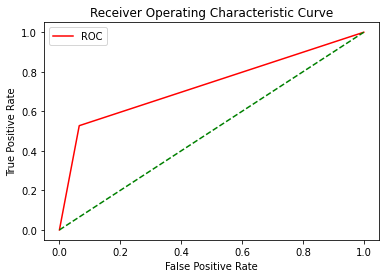

In [772]:
lgb_model = LGBMClassifier(**study.best_params)
lgb_model.fit(X_train,y_train, eval_metric= 'f1', verbose = 0)
pred = lgb_model.predict_proba(X_test)[:,1]
print(f1_score(y_test,list(map(lambda x: round(x),pred))))
fper, tper, thresholds = roc_curve(y_test, list(map(lambda x: round(x),pred)))
plot_roc_curve(fper, tper)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

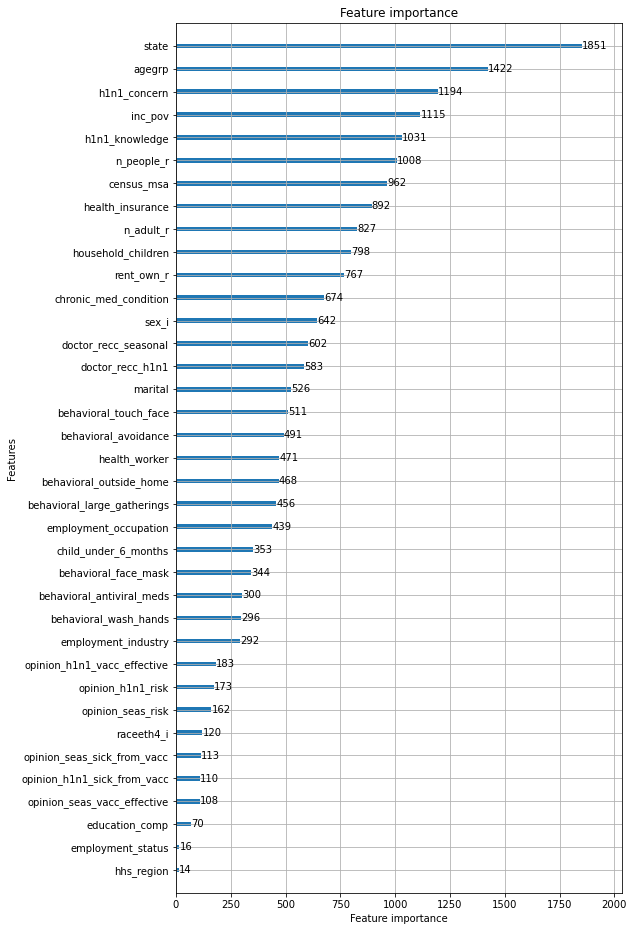

In [769]:
plot_importance(lgb_model,figsize=(8,16))

In [773]:
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
test = EDA(test)
test_casted = type_casting(test,type_feature)
sub = list(map(round,lgb_model.predict_proba(test_casted)[:,1]))
submission=pd.DataFrame(sub,columns=['vacc_h1n1_f'])
submission.index.name='Id'
submission.to_csv('submission.csv')

- kaggle score : 0.57239

In [774]:
best_param = {'min_data_in_leaf': 1, 'max_depth': 8, 'num_leaves': 252, 'min_child_samples': 56, 'min_child_weight': 0.8149235713004346, 'reg_lambda': 0.00024325070512654304, 'reg_alpha': 0.0011639649878337978}

### Encoding

#### One Hot Encoding

c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.5921052631578947


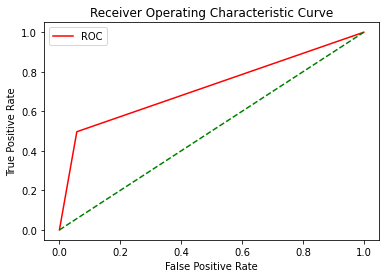

In [776]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(encoder(X_train,type_feature),y_train, eval_metric= 'f1', verbose = 0)
pred = lgb_model.predict_proba(encoder(X_test,type_feature))[:,1]
print(f1_score(y_test,list(map(lambda x: round(x),pred))))
fper, tper, thresholds = roc_curve(y_test, list(map(lambda x: round(x),pred)))
plot_roc_curve(fper, tper)

#### Catboost Encoding

In [779]:
from category_encoders.cat_boost import CatBoostEncoder
CBE_encoder = CatBoostEncoder()
X_train_cbe = CBE_encoder.fit_transform(X_train, y_train,cols=[x for x in X_train.columns if type_feature[x]=='nominal'])
X_test_cbe = CBE_encoder.transform(X_test)

c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
0.489137590520079


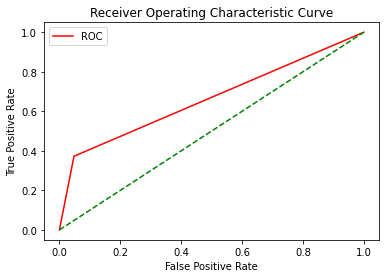

In [781]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(X_train_cbe,y_train, eval_metric= 'f1', verbose = 0)
pred = lgb_model.predict_proba(X_test_cbe)[:,1]
print(f1_score(y_test,list(map(lambda x: round(x),pred))))
fper, tper, thresholds = roc_curve(y_test, list(map(lambda x: round(x),pred)))
plot_roc_curve(fper, tper)

### Feature Engineering

#### Feature Selection

##### Filter method

- Information value

In [1108]:
def iv_woe(data, target, bins=10):
    newDF = pd.DataFrame()
    cols = data.columns
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
    return newDF

In [1109]:
iv = iv_woe(data = df.drop('vacc_seas_f',axis=1), target = 'vacc_h1n1_f')

In [1110]:
iv = iv.sort_values(by='IV',ascending=False)
iv.head(5)

Variable        IV
0             doctor_recc_h1n1  0.791771
0            opinion_h1n1_risk  0.602018
0  opinion_h1n1_vacc_effective  0.542162
0            opinion_seas_risk  0.395579
0          employment_industry  0.285576

In [1111]:
f1_lst = []
for i in range(1,len(iv)+1):
    selected = iv.head(i)['Variable'].tolist()
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test[selected])[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    f1_lst.append([i,f1])
iv_res = pd.DataFrame(f1_lst,columns=['num_s','f1'])
clear_output()

<AxesSubplot:xlabel='num_s'>

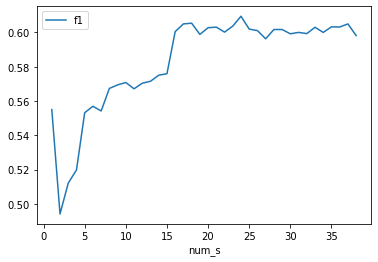

In [1112]:
iv_res.plot(x='num_s',y='f1')

- custom filter

In [1113]:
def custom_filter(train,df,type_feature):
    custom_u = []
    custom_c = []
    for column in train.columns:
        c_value=0
        for uniq in df[column].dropna().unique():
            tg1 = df[df['vacc_h1n1_f']==1]
            tg0 = df[df['vacc_h1n1_f']==0]
            tg1u = tg1[tg1[column]==uniq]
            tg0u = tg0[tg0[column]==uniq]
            u_value = abs(len(tg1u)/len(tg1)-len(tg0u)/len(tg0))*(len(tg1u)+len(tg0u))/len(df[column].dropna())
            c_value+=u_value
            if type_feature[column]=='nominal':
                custom_u.append([f'{column},{uniq}',u_value])
        custom_c.append([column,c_value])
    custom_u = pd.DataFrame(custom_u,columns=['name','value'])
    custom_c = pd.DataFrame(custom_c,columns=['col','value'])
    return custom_u, custom_c


In [1114]:
custom_u, custom_c = custom_filter(X_train,df,type_feature)

In [1115]:
custom_u.sort_values(by='value',ascending=False).head(10)

name     value
0                               h1n1_knowledge,1.0  0.076055
9                       opinion_h1n1_risk,Very Low  0.063035
4   opinion_h1n1_vacc_effective,Somewhat Effective  0.055152
3       opinion_h1n1_vacc_effective,Very Effective  0.053066
22  opinion_seas_vacc_effective,Somewhat Effective  0.050740
10                  opinion_h1n1_risk,Somewhat Low  0.043929
21      opinion_seas_vacc_effective,Very Effective  0.041605
27                  opinion_seas_risk,Somewhat Low  0.041502
29                      opinion_seas_risk,Very Low  0.034139
15    opinion_h1n1_sick_from_vacc,Not Very Worried  0.031031

In [1116]:
custom_c = custom_c.sort_values(by='value',ascending=False)
custom_c.head(10)

col     value
9              doctor_recc_h1n1  0.367475
13             health_insurance  0.244576
10         doctor_recc_seasonal  0.214839
14                health_worker  0.198240
16            opinion_h1n1_risk  0.140927
4          behavioral_face_mask  0.135930
15  opinion_h1n1_vacc_effective  0.131317
2     behavioral_antiviral_meds  0.126331
19            opinion_seas_risk  0.108199
1                h1n1_knowledge  0.103123

In [1117]:
f1_lst = []
for i in range(1,len(custom_c)+1):
    selected = custom_c.head(i)['col'].tolist()
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test[selected])[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    f1_lst.append([i,f1])
cus_res = pd.DataFrame(f1_lst,columns=['num_s','f1'])
clear_output()

<AxesSubplot:xlabel='num_s'>

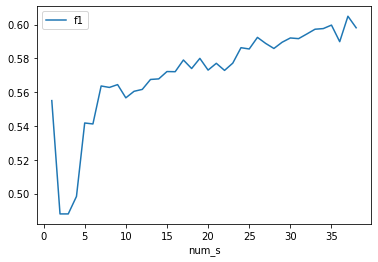

In [1118]:
cus_res.plot(x='num_s',y='f1')

##### wrapper method

- Feature Importance

In [1119]:
import shap

In [1156]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(X_train,y_train, eval_metric= 'f1', verbose = 0)
shap.initjs()
explainer = shap.TreeExplainer(lgb_model)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


In [1167]:
pred = pd.Series(list(map(np.round,lgb_model.predict_proba(X_test)[:,1])))
p1_index = pred == 1
p0_index = pred == 0
a1_index = y_test == 1
a0_index = y_test == 0
tp_index = np.logical_and(p1_index,a1_index).tolist()
fp_index = np.logical_and(p1_index,a0_index).tolist()
tn_index = np.logical_and(p0_index,a0_index).tolist()
fn_index = np.logical_and(p0_index,a1_index).tolist()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


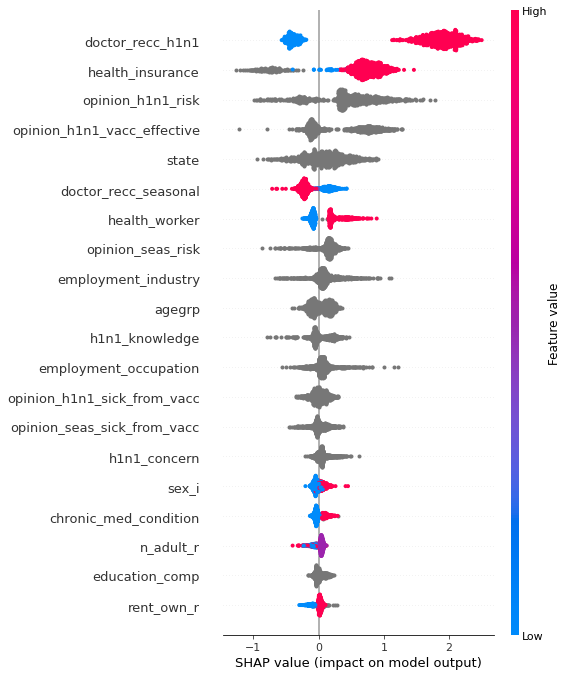

In [1182]:
shap_values = explainer.shap_values(X_test.iloc[tp_index])
shap.summary_plot(shap_values[1], X_test.iloc[tp_index])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


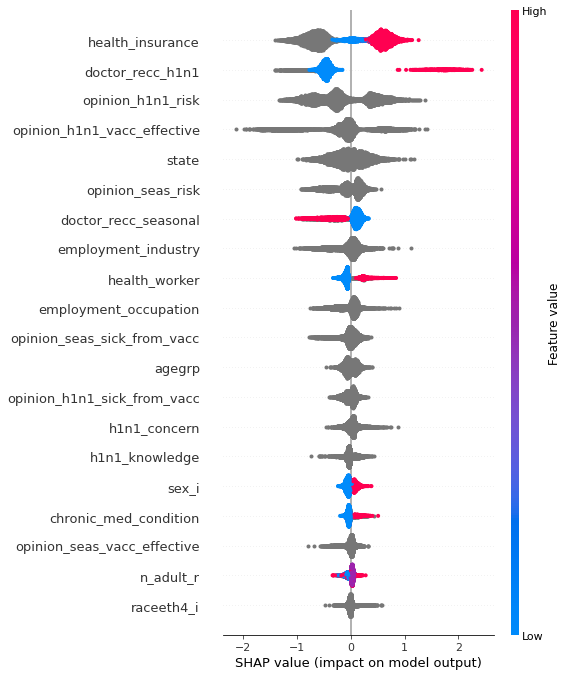

In [1183]:
shap_values = explainer.shap_values(X_test.iloc[tn_index])
shap.summary_plot(shap_values[1], X_test.iloc[tn_index])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


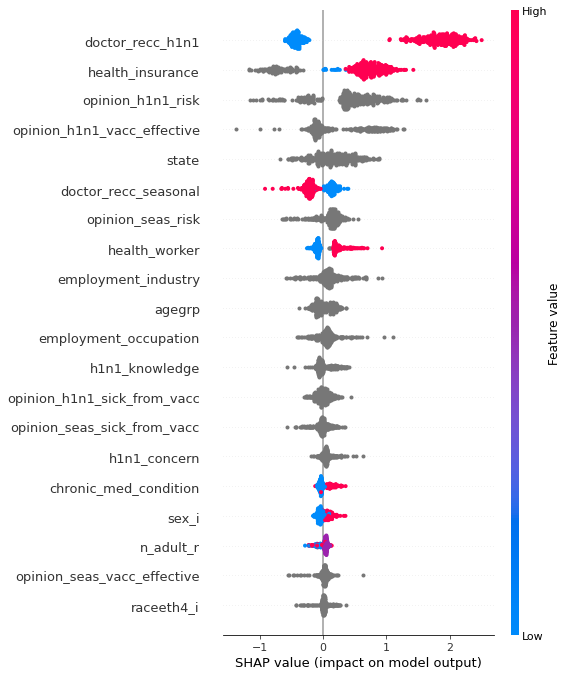

In [1184]:
shap_values = explainer.shap_values(X_test.iloc[fp_index])
shap.summary_plot(shap_values[1], X_test.iloc[fp_index])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


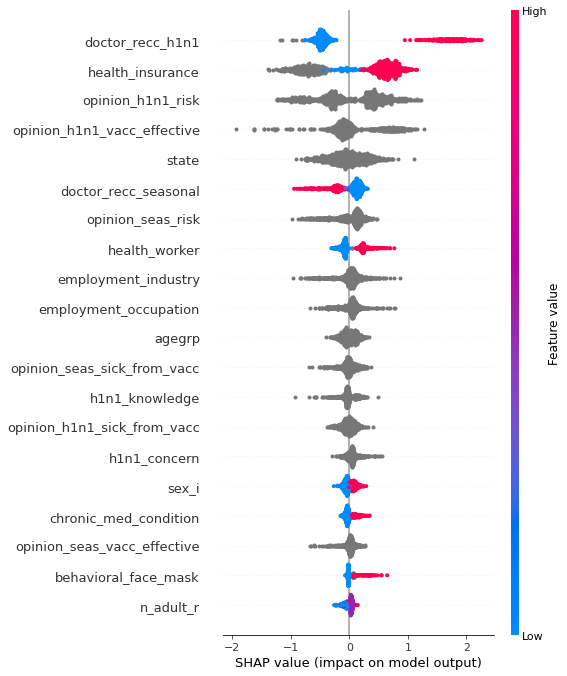

In [1185]:
shap_values = explainer.shap_values(X_test.iloc[fn_index])
shap.summary_plot(shap_values[1], X_test.iloc[fn_index])

In [983]:
row = X_test.iloc[[23]]
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    link='logit'
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [821]:
f1_lst = []
for col in X_train.columns:
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train.drop(col,axis=1),y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test.drop(col,axis=1))[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    f1_lst.append([col,f1])
f_i = pd.DataFrame(f1_lst,columns=['dcol','f1'])
f_i = f_i.sort_values(by='f1')
clear_output()

In [822]:
f_i.head(10)

dcol        f1
9              doctor_recc_h1n1  0.530312
13             health_insurance  0.561527
16            opinion_h1n1_risk  0.584561
37                        state  0.590882
15  opinion_h1n1_vacc_effective  0.591730
31                    n_adult_r  0.596573
20  opinion_seas_sick_from_vacc  0.598365
10         doctor_recc_seasonal  0.598536
14                health_worker  0.599124
4          behavioral_face_mask  0.599417

In [849]:
f1_lst = []
for i in range(1,len(f_i)+1):
    selected = f_i.head(i)['dcol'].tolist()
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test[selected])[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    f1_lst.append([i,f1])
fi_res = pd.DataFrame(f1_lst,columns=['num_s','f1'])
clear_output()

<AxesSubplot:xlabel='num_s'>

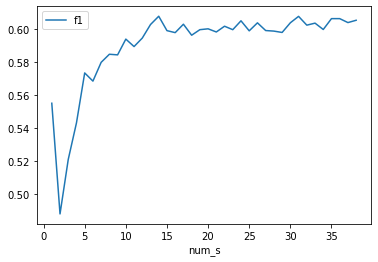

In [824]:
fi_res.plot(x='num_s',y='f1')

- Akaike Information Criterion

In [845]:
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
def all_aic(train,target):
    aic=[]
    for column in train.columns:
        x = train[column].dropna()
        y=target[x.index]
        model = Logit(np.array(y),np.array(sm.add_constant(x),dtype=float)).fit(method='bfgs')
        aic.append([column,model.aic,model.bic])
    return pd.DataFrame(aic,columns=['col','aic','bic'])

In [827]:
from sklearn.preprocessing import LabelEncoder

In [837]:
def label_encoder(df):
    data = copy.deepcopy(df)
    for col in [x for x in data.columns if type_feature[x]=='nominal']:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
    return data
X_train_le = label_encoder(X_train)

In [846]:
aic = all_aic(X_train_le,target['vacc_h1n1_f'])
aic = aic.sort_values(by=['aic'])
clear_output()

In [830]:
aic.head(10)

col           aic           bic
13             health_insurance  22167.258941  22182.839355
0                  h1n1_concern  27355.196315  27371.602833
3          behavioral_avoidance  27529.050475  27545.442640
8         behavioral_touch_face  27535.409579  27551.806813
5         behavioral_wash_hands  27582.483501  27598.886755
2     behavioral_antiviral_meds  27596.583391  27612.984417
4          behavioral_face_mask  27598.723615  27615.128724
6   behavioral_large_gatherings  27651.283663  27667.684616
7       behavioral_outside_home  27673.461475  27689.861833
9              doctor_recc_h1n1  30723.486793  30740.215442

In [851]:
f1_lst = []
for i in range(1,len(aic)+1):
    selected = aic.head(i)['col'].tolist()
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test[selected])[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    f1_lst.append([i,f1])
aic_res = pd.DataFrame(f1_lst,columns=['num_s','f1'])
clear_output()

<AxesSubplot:xlabel='num_s'>

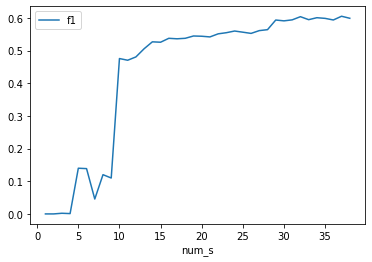

In [839]:
aic_res.plot(x='num_s',y='f1')

##### Result of Feature Selection

In [853]:
print(iv_res.sort_values(by='f1',ascending=False).head(1))
print(cus_res.sort_values(by='f1',ascending=False).head(1))
print(fi_res.sort_values(by='f1',ascending=False).head(1))
print(aic_res.sort_values(by='f1',ascending=False).head(1))

    num_s        f1
23     24  0.609425
    num_s        f1
36     37  0.604949
    num_s        f1
13     14  0.607735
    num_s        f1
36     37  0.605179


In [1092]:
selected = f_i.head(14)['dcol'].tolist()

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
0.6077348066298343


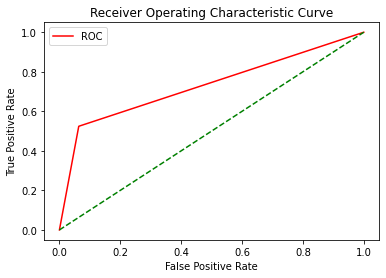

In [1093]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
pred = lgb_model.predict_proba(X_test[selected])[:,1]
print(f1_score(y_test,list(map(lambda x: round(x),pred))))
fper, tper, thresholds = roc_curve(y_test, list(map(lambda x: round(x),pred)))
plot_roc_curve(fper, tper)

In [860]:
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
test = EDA(test)
test_casted = type_casting(test,type_feature)
sub = list(map(round,lgb_model.predict_proba(test_casted[selected])[:,1]))
submission=pd.DataFrame(sub,columns=['vacc_h1n1_f'])
submission.index.name='Id'
submission.to_csv('submission.csv')

- kaggle score : 0.55694

In [1105]:
selected = iv.head(24)['Variable'].tolist()

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
0.5845049356865091


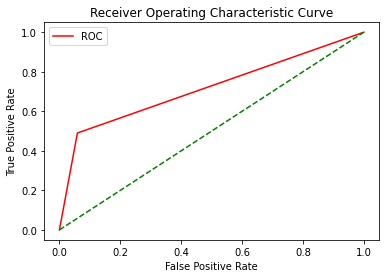

In [1106]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
pred = lgb_model.predict_proba(X_test[selected])[:,1]
print(f1_score(y_test,list(map(lambda x: round(x),pred))))
fper, tper, thresholds = roc_curve(y_test, list(map(lambda x: round(x),pred)))
plot_roc_curve(fper, tper)

In [868]:
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
test = EDA(test)
test_casted = type_casting(test,type_feature)
sub = list(map(round,lgb_model.predict_proba(test_casted[selected])[:,1]))
submission=pd.DataFrame(sub,columns=['vacc_h1n1_f'])
submission.index.name='Id'
submission.to_csv('submission.csv')

- kaggle score : 0.57231

In [1097]:
selected = ['doctor_recc_h1n1',
 'opinion_h1n1_risk',
 'opinion_h1n1_vacc_effective',
 'opinion_seas_risk',
 'employment_industry',
 'employment_occupation',
 'doctor_recc_seasonal',
 'opinion_seas_vacc_effective',
 'health_worker',
 'agegrp',
 'h1n1_knowledge',
 'employment_status',
 'h1n1_concern',
 'health_insurance',
 'education_comp',
 'state',
 'opinion_h1n1_sick_from_vacc',
 'household_children',
 'behavioral_wash_hands',
 'hhs_region',
 'behavioral_face_mask',
 'n_people_r',
 'behavioral_touch_face',
 'chronic_med_condition']

In [1095]:
dropcols = [x for x in X_train.columns if x not in selected]

- 24 / 38 features selected

#### Feature Extraction

In [1085]:
def simple_train(X_train,y_train,X_test):
    lgb_model = LGBMClassifier(**best_param)
    lgb_model.fit(X_train.drop(dropcols,axis=1),y_train, eval_metric= 'f1', verbose = 0)
    pred = lgb_model.predict_proba(X_test.drop(dropcols,axis=1))[:,1]
    f1 = f1_score(y_test,list(map(lambda x: round(x),pred)))
    return f1

In [1098]:
lgb_model = LGBMClassifier(**best_param)
lgb_model.fit(X_train[selected],y_train, eval_metric= 'f1', verbose = 0)
pred = lgb_model.predict_proba(X_test[selected])[:,1]
f1_score(y_test,list(map(lambda x: round(x),pred)))

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


0.6094246892165366

##### FE1 : ordinal variable

In [ ]:
# EDA issue 1 : opinion
def fe1_1_1(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_h1n1_vacc_effective.replace('Not At All Effective',1.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Not Very Effective',1.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Somewhat Effective',2.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Very Effective',3.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_h1n1_vacc_effective'] = 'ordinal'

    return df_temp, type_feature_temp
def fe1_1_2(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_h1n1_vacc_effective.replace('Not At All Effective',1.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Not Very Effective',2.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Somewhat Effective',3.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Very Effective',4.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_h1n1_vacc_effective'] = 'ordinal'

    return df_temp, type_feature_temp

def fe1_2_1(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp.opinion_h1n1_risk.replace('Very Low',1.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Somewhat Low',2.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Dont Know',3.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Refused',3.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Somewhat High',4.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Very High',5.0,inplace=True)
    type_feature_temp['opinion_h1n1_risk'] = 'ordinal'
    return df_temp, type_feature_temp
    
def fe1_2_2(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp.opinion_h1n1_risk.replace('Very Low',0.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Somewhat Low',0.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Refused',np.nan,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Somewhat High',1.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Very High',1.0,inplace=True)
    type_feature_temp['opinion_h1n1_risk'] = 'bool'
    return df_temp, type_feature_temp


def fe1_3_1(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_h1n1_sick_from_vacc.replace('Not At All Worried',1.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Not Very Worried',2.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Somewhat Worried',3.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Very Worried',4.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_h1n1_sick_from_vacc'] = 'ordinal'

    return df_temp, type_feature_temp
def fe1_3_2(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_h1n1_sick_from_vacc.replace('Not At All Worried',0.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Not Very Worried',0.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Somewhat Worried',1.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Very Worried',1.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_h1n1_sick_from_vacc'] = 'bool'

    return df_temp, type_feature_temp

def fe1_4_1(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_seas_vacc_effective.replace('Not At All Effective',1.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Not Very Effective',1.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Somewhat Effective',2.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Very Effective',3.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_seas_vacc_effective'] = 'ordinal'

    return df_temp, type_feature_temp
def fe1_4_2(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_seas_vacc_effective.replace('Not At All Effective',0.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Not Very Effective',0.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Somewhat Effective',1.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Very Effective',1.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_seas_vacc_effective'] = 'bool'

    return df_temp, type_feature_temp
def fe1_5_1(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_seas_risk.replace('Very Low',1.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Somewhat Low',2.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Dont Know',3.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Refused',3.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Somewhat High',4.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Very High',5.0,inplace=True)
    type_feature_temp['opinion_seas_risk'] = 'ordinal'

    return df_temp, type_feature_temp
def fe1_5_2(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_seas_risk.replace('Very Low',0.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Somewhat Low',0.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_seas_risk.replace('Refused',np.nan,inplace=True)
    df_temp.opinion_seas_risk.replace('Somewhat High',1.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Very High',1.0,inplace=True)
    type_feature_temp['opinion_seas_risk'] = 'bool'

    return df_temp, type_feature_temp

In [886]:
temp1, temp2 = fe1_1_1(X_train,type_feature)
temp3, temp2 = fe1_1_1(X_test, type_feature)
f1_fe1_1_1 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
temp1, temp2 = fe1_1_2(X_train,type_feature)
temp3, temp2 = fe1_1_2(X_test, type_feature)
f1_fe1_1_2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
temp1, temp2 = fe1_2_1(X_train,type_feature)
temp3, temp2 = fe1_2_1(X_test, type_feature)
f1_fe1_2_1 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
temp1, temp2 = fe1_2_2(X_train,type_feature)
temp3, temp2 = fe1_2_2(X_test, type_feature)
f1_fe1_2_2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
temp1, temp2 = fe1_3_1(X_train,type_feature)
temp3, temp2 = fe1_3_1(X_test, type_feature)
f1_fe1_3_1 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
temp1, temp2 = fe1_3_2(X_train,type_feature)
temp3, temp2 = fe1_3_2(X_test, type_feature)
f1_fe1_3_2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
temp1, temp2 = fe1_4_1(X_train,type_feature)
temp3, temp2 = fe1_4_1(X_test, type_feature)
f1_fe1_4_1 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
temp1, temp2 = fe1_4_2(X_train,type_feature)
temp3, temp2 = fe1_4_2(X_test, type_feature)
f1_fe1_4_2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
temp1, temp2 = fe1_5_1(X_train,type_feature)
temp3, temp2 = fe1_5_1(X_test, type_feature)
f1_fe1_5_1 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
temp1, temp2 = fe1_5_2(X_train,type_feature)
temp3, temp2 = fe1_5_2(X_test, type_feature)
f1_fe1_5_2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1


In [887]:
print(f'f1_fe1_1_1 : {f1_fe1_1_1}')
print(f'f1_fe1_1_2 : {f1_fe1_1_2}')
print(f'f1_fe1_2_1 : {f1_fe1_2_1}')
print(f'f1_fe1_2_2 : {f1_fe1_2_2}')
print(f'f1_fe1_3_1 : {f1_fe1_3_1}')
print(f'f1_fe1_3_2 : {f1_fe1_3_2}')
print(f'f1_fe1_4_1 : {f1_fe1_4_1}')
print(f'f1_fe1_4_2 : {f1_fe1_4_2}')
print(f'f1_fe1_5_1 : {f1_fe1_5_1}')
print(f'f1_fe1_5_2 : {f1_fe1_5_2}')


f1_fe1_1_1 : 0.600349040139616
f1_fe1_1_2 : 0.606165370210314
f1_fe1_2_1 : 0.5976072366501313
f1_fe1_2_2 : 0.5976811594202899
f1_fe1_3_1 : 0.6002886002886003
f1_fe1_3_2 : 0.6013904982618772
f1_fe1_4_1 : 0.605972745723398
f1_fe1_4_2 : 0.5968162083936325
f1_fe1_5_1 : 0.6032482598607889
f1_fe1_5_2 : 0.6045428072218986


- lgbmE : fe1_2_2, fe1_4_1, fe1_5_1
- OHE : x
- CBE : fe1_1_1, fe1_2_1, fe_1_3_1, fe1_4_1, fe_1_5_1

##### FE2 : behavior score

In [875]:
# EDA issue 2 : behavior
def fe2(df, type_feature):
    '''
    behavior score : sum of behavior inquiries (weight = 1)
    '''
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp['behavior_score'] = df_temp['behavioral_antiviral_meds']+df_temp['behavioral_avoidance']+df_temp['behavioral_face_mask']+df_temp['behavioral_wash_hands']+df_temp['behavioral_large_gatherings']+df_temp['behavioral_outside_home']+df_temp['behavioral_touch_face']
    type_feature_temp['behavior_score'] = 'ratio'
    return df_temp, type_feature_temp

In [1002]:
temp1, temp2 = fe2(X_train,type_feature)
temp3, temp2 = fe2(X_test,type_feature)
f1_fe2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe2 : {f1_fe2}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe2 : 0.6026604973973395


In [890]:
def fe2_2(df, type_feature,w1,w2,w3,w4,w5,w6,w7):
    '''
    behavior score : sum of behavior inquiries (weight = 1)
    '''
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp['behavior_score'] = w1*df_temp['behavioral_antiviral_meds']+w2*df_temp['behavioral_avoidance']+w3*df_temp['behavioral_face_mask']+w4*df_temp['behavioral_wash_hands']+w5*df_temp['behavioral_large_gatherings']+w6*df_temp['behavioral_outside_home']+w7*df_temp['behavioral_touch_face']
    type_feature_temp['behavior_score'] = 'ratio'
    return df_temp, type_feature_temp

In [904]:
def find_weights(trial):  # `trial` is an object passed by Optuna.
    '''
    Optuna objective function for tuning hyperparameter
    '''
    
    w1 = trial.suggest_float("w1",0,1)
    w2 = trial.suggest_float("w2",0,1)
    w3 = trial.suggest_float("w3",0,1)
    w4 = trial.suggest_float("w4",0,1)
    w5 = trial.suggest_float("w5",0,1)
    w6 = trial.suggest_float("w6",0,1)
    w7 = trial.suggest_float("w7",0,1)
        
    train_, type_feature_ = fe2_2(X_train, type_feature,w1,w2,w3,w4,w5,w6,w7)
    test_, type_feature_ = fe2_2(X_test,type_feature,w1,w2,w3,w4,w5,w6,w7)
    f1 = simple_train(type_casting(train_,type_feature_), y_train, type_casting(test_,type_feature_))
    clear_output()
    return f1

In [909]:
study2 = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(random_seed),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, 
        max_resource=4, 
        reduction_factor=3
    ))
study2.optimize(find_weights, n_trials=30)
clear_output()

In [910]:
print('Minimum objective value: ' + str(study2.best_value))
print('Best parameter: ' + str(study2.best_params))

Minimum objective value: 0.6084425036390101
Best parameter: {'w1': 0.9855485051544729, 'w2': 0.046315266092896504, 'w3': 0.28684552887424286, 'w4': 0.2564707022128156, 'w5': 0.8293173710706446, 'w6': 0.7620652481112213, 'w7': 0.9679814718811517}


In [911]:
weights={
    'w1': 0.9855485051544729, 
    'w2': 0.046315266092896504, 
    'w3': 0.28684552887424286, 
    'w4': 0.2564707022128156, 
    'w5': 0.8293173710706446, 
    'w6': 0.7620652481112213, 
    'w7': 0.9679814718811517
    }

In [1006]:
temp1, temp2 = fe2_2(X_train,type_feature,**weights)
temp3, temp2 = fe2_2(X_test,type_feature,**weights)
f1_fe2_2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe2_2 : {f1_fe2_2}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe2_2 : 0.6084425036390101


##### FE3 : high cardinality

In [914]:
def logic_and(arr1,arr2):
    na1 = pd.isna(arr1)
    na2 = pd.isna(arr2)
    na = np.logical_and(na1,na2)
    res = np.logical_and(arr1,arr2)
    return list(map(lambda x: np.nan if x[1] else res[x[0]],enumerate(na)))
def logic_or(arr1,arr2):
    na1 = pd.isna(arr1)
    na2 = pd.isna(arr2)
    na = np.logical_or(na1,na2)
    res = np.logical_or(arr1,arr2)
    return list(map(lambda x: np.nan if x[1] else res[x[0]],enumerate(na)))
def logic_xor(arr1,arr2):
    na1 = pd.isna(arr1)
    na2 = pd.isna(arr2)
    na = np.logical_xor(na1,na2)
    res = np.logical_xor(arr1,arr2)
    return list(map(lambda x: np.nan if x[1] else res[x[0]],enumerate(na)))


In [923]:
# EDA issue 3 : high cardinality
def fe3(df,type_feature):
    df_temp=copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    hicar = [x for x in ['state','employment_occupation','employment_industry'] if x not in dropcols]
    df_temp.drop(hicar,axis=1,inplace=True)
    return df_temp, type_feature_temp

In [924]:
temp1, temp2 = fe3(X_train,type_feature)
temp3, temp2 = fe3(X_test,type_feature)
f1_fe3 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe3 : {f1_fe3}')

c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe3 : 0.5953079178885631


- lgmbE : fe3_1
- OHE : x
- CBE : fe3_1

##### FE4 : cluster

In [985]:
# EDA issue 4 : cluster
def fe4(df,type_feature):
    df_temp=copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp['cluster'] = clustering_results[0]
    type_feature_temp['cluster'] = 'nominal'

    return df_temp, type_feature_temp

In [ ]:
temp1, temp2 = fe4(X_train,type_feature)
temp3, temp2 = fe4(X_test,type_feature)
f1_fe4 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe4 : {f1_fe4}')

- lgbmE : better
- OHE : worse
- CBE : worse

##### FE5 : Imbalanced target

In [941]:
# EDA issue 5 : Imbalanced target
def fe5(train,target):
    n = len(target[target==1])
    a=np.array(train.iloc[target[target==0].index].sample(n,random_state=42,axis=0).index)
    b=np.array(target[target==1].index)
    return np.concatenate((a,b))

In [950]:
index = fe5(X_train.reset_index(drop=True),y_train.reset_index(drop=True))
f1_fe5 = simple_train(X_train.iloc[index].reset_index(drop=True),y_train.iloc[index].reset_index(drop=True),X_test)
print(f'f1_fe5 : {f1_fe5}')

c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe5 : 0.611808269903312


- sampling is better than lgbm's scale pos weight

##### FE6 : students

##### FE7 : logical combination

In [1012]:
# feature extract using iteration
def ex_test(train,target,type_feature):
    train_temp = copy.deepcopy(train)
    type_feature_temp = copy.deepcopy(type_feature)
    bins=10

    newDF = pd.DataFrame()

    bin_cols=[]
    for column in train_temp.columns:
        if len(train_temp[column].dropna().unique()) == 2:
            bin_cols.append(column)
    df_bin = train_temp[bin_cols]
    for col1, col2 in itertools.combinations(df_bin.columns,2):
        df_bin_temp = df_bin[[col1,col2]]
        df_lo = pd.DataFrame()

        na1 = pd.isna(df_bin_temp[col1])
        na2 = pd.isna(df_bin_temp[col2])
        na_and = np.logical_and(na1,na2)
        na_or = np.logical_or(na1,na2)
        logand = np.logical_and(df_bin_temp[col1],df_bin_temp[col2])
        logor = np.logical_or(df_bin_temp[col1],df_bin_temp[col2])
        logxor = np.logical_xor(df_bin_temp[col1],df_bin_temp[col2])

        df_lo['and'] = list(map(lambda x: np.nan if x[1] else logand[x[0]],enumerate(na_or)))
        df_lo['or'] = list(map(lambda x: np.nan if x[1] else logor[x[0]],enumerate(na_and)))
        df_lo['xor'] = list(map(lambda x: np.nan if x[1] else logxor[x[0]],enumerate(na_or)))
        for lovar in df_lo.columns:
            d0 = pd.DataFrame({'x': df_lo[lovar], 'y': target['vacc_h1n1_f'].iloc[df_bin_temp.index]})
            d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
            d.columns = ['Cutoff', 'N', 'Events']
            d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
            d['Non-Events'] = d['N'] - d['Events']
            d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
            d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
            d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
            print(f'{col1}_{lovar}_{col2}',d['IV'].sum())
            if d['IV'].sum()>0.6:
                temp =pd.DataFrame([[f'{col1}_{lovar}_{col2}',d['IV'].sum()]], columns = ["Variable", "IV"])
                newDF=pd.concat([newDF,temp], axis=0)
    return newDF


In [1013]:
a=ex_test(encoder(type_casting(train,type_feature,),type_feature),target,type_feature)

behavioral_antiviral_meds_and_behavioral_avoidance 0.007360977246618094
behavioral_antiviral_meds_or_behavioral_avoidance 0.012968034085142915
behavioral_antiviral_meds_xor_behavioral_avoidance 0.004632260928751225
behavioral_antiviral_meds_and_behavioral_face_mask 0.005272834602532347
behavioral_antiviral_meds_or_behavioral_face_mask 0.03589817563484668
behavioral_antiviral_meds_xor_behavioral_face_mask 0.028332217677159988
behavioral_antiviral_meds_and_behavioral_wash_hands 0.01207382103944573
behavioral_antiviral_meds_or_behavioral_wash_hands 0.03537946961200636
behavioral_antiviral_meds_xor_behavioral_wash_hands 0.010998309930800044
behavioral_antiviral_meds_and_behavioral_large_gatherings 0.005483302391961146
behavioral_antiviral_meds_or_behavioral_large_gatherings 0.004806456502935489
behavioral_antiviral_meds_xor_behavioral_large_gatherings 0.0015350355874915156
behavioral_antiviral_meds_and_behavioral_outside_home 0.004707314785287994
behavioral_antiviral_meds_or_behavioral_out

- all results include 'doctor_recc_h1n1'

In [1020]:
# IV of doctor_recc_h1n1 : 0.791771
a[a['IV']>0.6].sort_values(by='IV',ascending=False).head(10)

Variable        IV
0              doctor_recc_h1n1_and_health_insurance  0.794322
0  doctor_recc_h1n1_xor_employment_industry_Manag...  0.792328
0  doctor_recc_h1n1_xor_employment_industry_Armed...  0.791373
0  doctor_recc_h1n1_xor_employment_occupation_Mil...  0.791197
0  doctor_recc_h1n1_xor_opinion_h1n1_sick_from_va...  0.787907
0     doctor_recc_h1n1_xor_opinion_seas_risk_Refused  0.787119
0  doctor_recc_h1n1_xor_opinion_seas_sick_from_va...  0.786809
0     doctor_recc_h1n1_xor_opinion_h1n1_risk_Refused  0.786547
0  doctor_recc_h1n1_xor_opinion_seas_vacc_effecti...  0.785496
0  doctor_recc_h1n1_xor_opinion_h1n1_vacc_effecti...  0.781353

In [ ]:
# result1
['doctor_recc_h1n1_or_employment_occupation_Healthcare_Practitioners_and_Technical_Occupations',
 'doctor_recc_h1n1_or_opinion_h1n1_risk_Very_High',
 'doctor_recc_h1n1_or_employment_industry_Armed_Forces',
 'doctor_recc_h1n1_or_employment_occupation_Military_Specific_Occupations',
 'doctor_recc_h1n1_xor_employment_industry_Management_of_Companies_and_Enterprises_Industries',
 'doctor_recc_h1n1_or_employment_industry_Management_of_Companies_and_Enterprises_Industries']

In [1016]:
# result2
['doctor_recc_h1n1_and_health_insurance',
 'doctor_recc_h1n1_xor_employment_industry_Management_of_Companies_and_Enterprises_Industries']

['doctor_recc_h1n1_and_health_insurance',
 'doctor_recc_h1n1_xor_employment_industry_Management_of_Companies_and_Enterprises_Industries']

- doctor_recc_h1n1_or_employment_occupation_Healthcare

In [1025]:
def fe7(train,type_feature):
    train_temp = copy.deepcopy(train)
    type_feature_temp = copy.deepcopy(type_feature)
    a = train_temp['doctor_recc_h1n1'].tolist()
    b = train_temp['employment_industry'].map(lambda x: True if x == 'Management of Companies and Enterprises Industries' else (np.nan if pd.isna(x) else False)).tolist()
    na1 = pd.isna(a)
    na2 = pd.isna(b)
    na_or = np.logical_or(na1,na2)
    logand = np.logical_and(a,b)
    train_temp['logires'] = list(map(lambda x: np.nan if x[1] else logand[x[0]],enumerate(na_or)))
    train_temp['logires'] = train_temp['logires'].astype('float')
    type_feature_temp['logires'] = 'bool'
    return train_temp, type_feature_temp

In [1026]:
temp1, temp2 = fe7(X_train,type_feature)
temp3, temp2 = fe7(X_test,type_feature)
f1_fe7 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe7 : {f1_fe7}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe7 : 0.6006352873231302


In [1072]:
def fe7_2(train,type_feature):
    train_temp = copy.deepcopy(train)
    type_feature_temp = copy.deepcopy(type_feature)
    a = train_temp['employment_occupation'] =='Healthcare Practitioners and Technical Occupations'
    b = train_temp['employment_industry'] =='Health Care and Social Assistance Industries'
    c = (a|b).tolist()
    train_temp['DRHor'] = train_temp['doctor_recc_h1n1']+c
    train_temp['DRHor'] = train_temp['DRHor'].map(lambda x: 1 if not pd.isna(x) else x)
    train_temp['DRHor'] = train_temp['DRHor'].astype('float')
    type_feature_temp['DRHor'] = 'bool'
    return train_temp, type_feature_temp

In [1073]:
temp1, temp2 = fe7_2(X_train,type_feature)
temp3, temp2 = fe7_2(X_test,type_feature)
f1_fe7_2 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe7_2 : {f1_fe7_2}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe7_2 : 0.6046645551396486


##### FE8 : household children

In [1077]:
def fe8(train, type_feature):
    train_temp = copy.deepcopy(train)
    type_feature_temp = copy.deepcopy(type_feature)
    train_temp['household_children'] = train_temp['household_children'].map(lambda x: False if x==0 else (np.nan if pd.isna(x) else True))
    train_temp['household_children'] = train_temp['household_children'].astype('float')
    type_feature_temp['household_children'] = 'bool'
    return train_temp, type_feature_temp

In [1078]:
temp1, temp2 = fe8(X_train,type_feature)
temp3, temp2 = fe8(X_test,type_feature)
f1_fe8 = simple_train(type_casting(temp1,temp2),y_train,type_casting(temp3,temp2))
print(f'f1_fe8 : {f1_fe8}')

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1
f1_fe8 : 0.5982065374602257


- bad idea

##### FE all

In [617]:
dropcols = [x for x in X_train.columns if x not in selected]
prior_w = {
    'w1': 0.06274118288143093,
    'w2': 0.9844194336163422,
    'w3': 0.230792818874879,
    'w4': 0.07324412868601282,
    'w5': 0.99100537047241,
    'w6': 0.8778262771966473,
    'w7': 0.8855500712474639
    }
 weights = {
    'w1': 0.9855485051544729, 
    'w2': 0.046315266092896504, 
    'w3': 0.28684552887424286, 
    'w4': 0.2564707022128156, 
    'w5': 0.8293173710706446, 
    'w6': 0.7620652481112213, 
    'w7': 0.9679814718811517
    }

index = fe5(X_train.reset_index(drop=True),y_train.reset_index(drop=True))
f1_fe5 = simple_train(X_train.iloc[index].reset_index(drop=True),y_train.iloc[index].reset_index(drop=True),X_test)
print(f'f1_fe5 : {f1_fe5}')



    

In [614]:
temp1, temp2 = fe_all_lgbme(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe_all_lgbme = simple_train(temp3.iloc[index],target.iloc[index])


In [615]:

temp1, temp2 = fe_all_ohe(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe_all_ohe = simple_train(encoder(temp3,temp2).iloc[index],target.iloc[index])


In [618]:
temp1, temp2 = fe_all_cbe(train,type_feature)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe_all_cbe = simple_train(train_cbe.iloc[index],target.iloc[index])


In [619]:
print(f1_fe_all_lgbme, f1_fe_all_ohe, f1_fe_all_cbe)

0.7692307692307693 0.7649746192893401 0.7704418486541391


In [621]:
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
test = EDA(test)
temp1, temp2 = fe_all_cbe(train,type_feature)
temp3, temp4 = fe_all_cbe(test,type_feature)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
test_cbe = CBE_encoder.transform(temp3)
X_train, X_test, y_train, y_test = train_test_split(train_cbe.iloc[index],target['vacc_h1n1_f'].iloc[index], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=random_seed)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=5, n_iter=25)
clear_output();
# 가장 큰 target값을 가지는 parameter 추출. 
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
    max_depth=int(max_target_param['params']['max_depth']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
sub = list(map(round,clf.predict_proba(test_cbe)[:,1]))

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=18
[1]	training's binary_logloss: 0.689497	valid_1's binary_logloss: 0.689659
[2]	training's binary_logloss: 0.685931	valid_1's binary_logloss: 0.686159
[3]	training's binary_logloss: 0.682434	valid_1's binary_logloss: 0.682729
[4]	training's binary_logloss: 0.679007	valid_1's binary_logloss: 0.679374
[5]	training's binary_logloss: 0.675656	valid_1's binary_logloss: 0.676065
[6]	training's binary_logloss: 0.672363	valid_1's binary_logloss: 0.672836
[7]	training's binary_logloss: 0.669139	valid_1's binary_logloss: 0.669667


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depr

[8]	training's binary_logloss: 0.665971	valid_1's binary_logloss: 0.666561
[9]	training's binary_logloss: 0.662858	valid_1's binary_logloss: 0.663508
[10]	training's binary_logloss: 0.659808	valid_1's binary_logloss: 0.660523
[11]	training's binary_logloss: 0.656822	valid_1's binary_logloss: 0.657571
[12]	training's binary_logloss: 0.653895	valid_1's binary_logloss: 0.654702
[13]	training's binary_logloss: 0.651018	valid_1's binary_logloss: 0.651871
[14]	training's binary_logloss: 0.648185	valid_1's binary_logloss: 0.649088
[15]	training's binary_logloss: 0.645411	valid_1's binary_logloss: 0.646403
[16]	training's binary_logloss: 0.642687	valid_1's binary_logloss: 0.643757
[17]	training's binary_logloss: 0.640016	valid_1's binary_logloss: 0.641139
[18]	training's binary_logloss: 0.63739	valid_1's binary_logloss: 0.638596
[19]	training's binary_logloss: 0.634806	valid_1's binary_logloss: 0.636078
[20]	training's binary_logloss: 0.632274	valid_1's binary_logloss: 0.63361
[21]	training's 

In [626]:
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
test = EDA(test)
temp1, temp2 = fe_all_cbe(train,type_feature)
temp3, temp4 = fe_all_cbe(test,type_feature)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
test_cbe = CBE_encoder.transform(temp3)
X_train, X_test, y_train, y_test = train_test_split(train_cbe,target['vacc_h1n1_f'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=random_seed)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=5, n_iter=25)
clear_output();
# 가장 큰 target값을 가지는 parameter 추출. 
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
    max_depth=int(max_target_param['params']['max_depth']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
sub = list(map(round,clf.predict_proba(test_cbe)[:,1]))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=1
[1]	training's binary_logloss: 0.54394	valid_1's binary_logloss: 0.542883
[2]	training's binary_logloss: 0.540545	valid_1's binary_logloss: 0.539619
[3]	training's binary_logloss: 0.53729	valid_1's binary_logloss: 0.536491
[4]	training's binary_logloss: 0.534161	valid_1's binary_logloss: 0.533482
[5]	training's binary_logloss: 0.53116	valid_1's binary_logloss: 0.530614
[6]	training's binary_logloss: 0.528272	valid_1's binary_logloss: 0.527832
[7]	training's binary_logloss: 0.525496	valid_1's binary_logloss: 0.525175
[8]	training's binary_logloss: 0.522815	valid_1's binary_logloss: 0.522635
[9]	training's binary_logloss: 0.520237	valid_1's binary_logloss: 0.520169
[10]	training's binary_logloss: 0.517754	valid_1's binary_logloss: 0.517783
[11]	training's binary_logloss: 0.515359	valid_1's binary_logloss: 0.515498


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depr

[12]	training's binary_logloss: 0.513048	valid_1's binary_logloss: 0.513308
[13]	training's binary_logloss: 0.510818	valid_1's binary_logloss: 0.511194
[14]	training's binary_logloss: 0.508676	valid_1's binary_logloss: 0.509136
[15]	training's binary_logloss: 0.506598	valid_1's binary_logloss: 0.507175
[16]	training's binary_logloss: 0.504597	valid_1's binary_logloss: 0.505271
[17]	training's binary_logloss: 0.502664	valid_1's binary_logloss: 0.503447
[18]	training's binary_logloss: 0.500791	valid_1's binary_logloss: 0.501675
[19]	training's binary_logloss: 0.498981	valid_1's binary_logloss: 0.499975
[20]	training's binary_logloss: 0.497231	valid_1's binary_logloss: 0.49834
[21]	training's binary_logloss: 0.495542	valid_1's binary_logloss: 0.496747
[22]	training's binary_logloss: 0.493911	valid_1's binary_logloss: 0.4952
[23]	training's binary_logloss: 0.492334	valid_1's binary_logloss: 0.493712
[24]	training's binary_logloss: 0.490805	valid_1's binary_logloss: 0.492283
[25]	training's

In [ ]:
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
test = EDA(test)
temp1, temp2 = fe_all_cbe(train,type_feature)
temp3, temp4 = fe_all_cbe(test,type_feature)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
test_cbe = CBE_encoder.transform(temp3)
X_train, X_test, y_train, y_test = train_test_split(train_cbe,target['vacc_h1n1_f'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=random_seed)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=5, n_iter=25)
clear_output();
# 가장 큰 target값을 가지는 parameter 추출. 
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
    max_depth=int(max_target_param['params']['max_depth']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
sub = list(map(round,clf.predict_proba(test_cbe)[:,1]))

In [627]:
submission=pd.DataFrame(sub,columns=['vacc_h1n1_f'])
submission.index.name='Id'
submission.to_csv('submission.csv')

In [629]:
submission.value_counts()

vacc_h1n1_f
0              21031
1               7073
dtype: int64

- controling target balance by random sampling won kaggle score 0.60890

- controling target balance by scale_pos_weight won kaggle score 0.61143

### Missing Value Imputation

#### Simple imputation

#### PMM imputation

#### Multiple imputation

In [ ]:
'''
strategy={}
for column in encoder(train_fe1,type_feature_fe1)[selected].columns:
    if len(encoder(train_fe1,type_feature_fe1)[selected][column].dropna().unique())==2:
        strategy[column]='bayesian binary logistic'
    else:
        strategy[column]='pmm'
strategy
'''

{'opinion_h1n1_risk_Very_Low': 'bayesian binary logistic',
 'behavioral_large_gatherings': 'bayesian binary logistic',
 'behavior_score': 'pmm',
 'doctor_recc_h1n1': 'bayesian binary logistic',
 'health_insurance': 'bayesian binary logistic',
 'health_worker': 'bayesian binary logistic',
 'doctor_recc_seasonal': 'bayesian binary logistic',
 'behavioral_avoidance': 'bayesian binary logistic',
 'behavioral_antiviral_meds': 'bayesian binary logistic',
 'behavioral_touch_face': 'bayesian binary logistic',
 'opinion_h1n1_vacc_effective_Very_Effective': 'bayesian binary logistic',
 'behavioral_outside_home': 'bayesian binary logistic',
 'behavioral_wash_hands': 'bayesian binary logistic',
 'opinion_h1n1_risk_Somewhat_Low': 'bayesian binary logistic',
 'h1n1_concern': 'pmm',
 'behavioral_face_mask': 'bayesian binary logistic'}

In [ ]:
'''
imp = MiceImputer(
    k=3,
    n=5,
    strategy=strategy, 
    imp_kwgs={"pmm": {"fill_value": "random",'neighbors':6}}, 
    #predictors={"salary": "all", "gender": ["salary", "education", "weight"]},
    visit="left-to-right", 
    return_list=True,
    seed=random_seed
    )
df_imputed=imp.fit_transform(encoder(train_fe1,type_feature_fe1)[selected].astype(float))
'''

C:\Users\gram\AppData\Roaming\Python\Python38\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gram\AppData\Roaming\Python\Python38\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gram\AppData\Roaming\Python\Python38\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


## XGBOOST & Grid search

## Output

In [ ]:
pred = clf.predict_proba(encoder(test,type_feature))
first_pred=pd.DataFrame(map(round,pred[:,1]),columns=['vacc_h1n1_f'])
first_pred.index.name='Id'
first_pred.to_csv('first_pred.csv')

In [ ]:
pred = clf.predict_proba(encoder(test,type_feature))
first_pred=pd.DataFrame(map(round,pred[:,1]),columns=['vacc_h1n1_f'])
first_pred.index.name='Id'
first_pred.to_csv('first_pred.csv')